In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 15.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt

# Import the correct ARIMA class
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# MSE AND RMSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/Proj5005/data_preprocessed')
!ls

Mounted at /content/gdrive
 2324_byhour_bylocation.csv
 byborough.ipynb
'Demand2023-2024(byhour)'
'Demand2023-2024(byhour-bypickuplocation)'
'Demand2023-2024(hour-location-mile quantile)'
 demand_hourly_peak.csv
 Demand_time_borough
 Impute_missing_valuies.ipynb
 NYC_Holidays_23_24.csv
'Other Vairable2023-2024(hour-location-mile quantile)'
'Other Variable2023-2024(byhour-bypickuplocation)'
'Other Variable2023-2024(byhour)-General'
 taxi_zone_lookup.csv


In [ ]:
df_2024 = pd.read_csv("Demand2023-2024(byhour)/order_counts_byhour2024.csv")
df_2023 = pd.read_csv("Demand2023-2024(byhour)/order_counts_byhour2023.csv")

In [ ]:
df = pd.concat([df_2023, df_2024], ignore_index=True)

In [ ]:
df

datetime_hour  order_count
0      2023-01-01 00:00:00        48359
1      2023-01-01 01:00:00        53356
2      2023-01-01 02:00:00        50743
3      2023-01-01 03:00:00        44659
4      2023-01-01 04:00:00        33567
...                    ...          ...
17539  2024-12-31 19:00:00        52993
17540  2024-12-31 20:00:00        64481
17541  2024-12-31 21:00:00        67659
17542  2024-12-31 22:00:00        67146
17543  2024-12-31 23:00:00        45731

[17544 rows x 2 columns]

In [ ]:
# Create exogenous variables
df['datetime_hour'] = pd.to_datetime(df['datetime_hour'])

In [ ]:
df['hour'] = df['datetime_hour'].dt.hour                # Hour of day (0–23)
df['dayofweek'] = df['datetime_hour'].dt.dayofweek      # Day of week (0=Mon, 6=Sun)
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['month'] = df['datetime_hour'].dt.month              # Month
df['day'] = df['datetime_hour'].dt.day                  # Day of month

In [ ]:
df_hol = pd.read_csv("NYC_Holidays_23_24.csv")
df_hol['Holidays'] = pd.to_datetime(df_hol['Holidays'])
df['date'] = df['datetime_hour'].dt.date
df['is_holiday'] = df['date'].isin(df_hol['Holidays']).astype(int)

<ipython-input-9-3504e8115286>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_hol['Holidays'] = pd.to_datetime(df_hol['Holidays'])


In [ ]:
exog = df.drop(columns=['order_count','datetime_hour','date'])  # drop target

<Axes: >

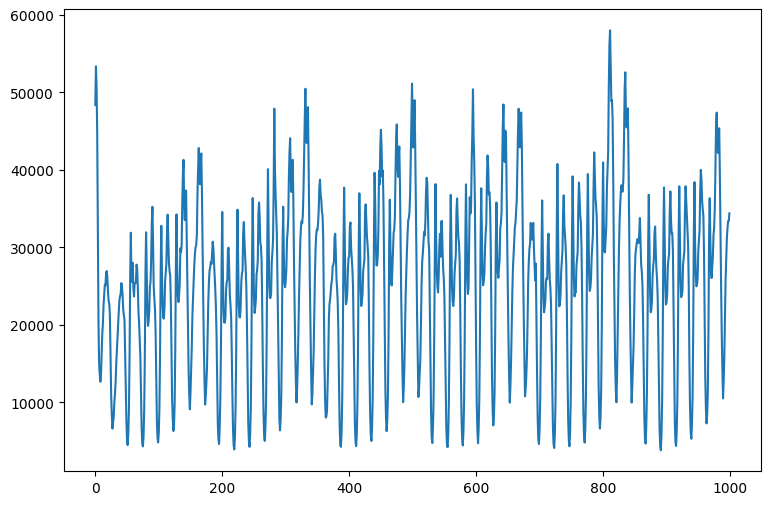

In [ ]:
df['order_count'].head(1000).plot(figsize = (9,6))

In [ ]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
stationarity = adfuller(df['order_count'])
print('Augmented Dickey Fuller p-value: %F' % stationarity[1])

Augmented Dickey Fuller p-value: 0.000000


In [ ]:
train_size = int(len(df) * 0.8)
train_set, test_set = df[:train_size], df[train_size:]

In [ ]:
exog_train_set = exog[:train_size]
exog_test_set = exog[train_size:]

In [ ]:
train_set

0        48359
1        53356
2        50743
3        44659
4        33567
         ...  
14030    30301
14031    31260
14032    31099
14033    35452
14034    35189
Name: order_count, Length: 14035, dtype: int64

In [ ]:
print(train_set.shape)
print(test_set.shape)

(14035,)
(3509,)


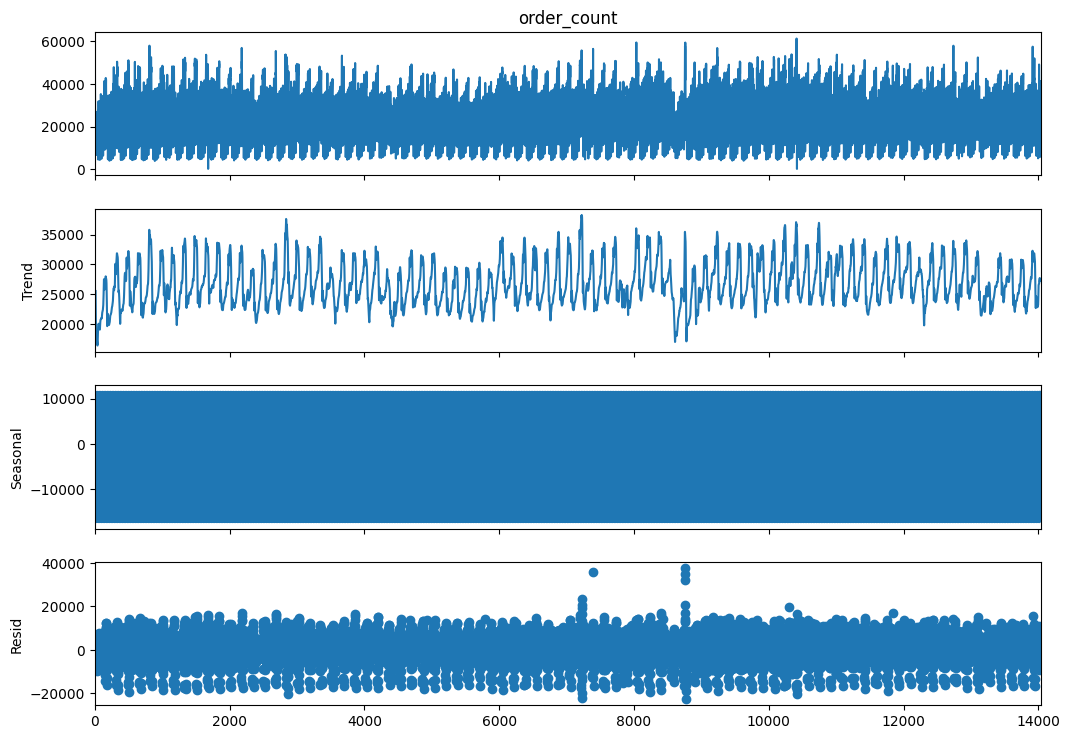

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your data is a Pandas Series with a DateTime index
# Example: train_set['order_count']

# Set the seasonal period (e.g., 24 for hourly data with daily cycle)
seasonal_period = 24

# Decompose
decomposition = seasonal_decompose(train_set['order_count'], model='additive', period=seasonal_period)

# Plot
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [ ]:
'''
small_train_size =  int(len(df_combined) * 0.4)
small_train_set = df_combined[:small_train_size]
'''

'\nsmall_train_size =  int(len(df_combined) * 0.4)\nsmall_train_set = df_combined[:small_train_size]\n'

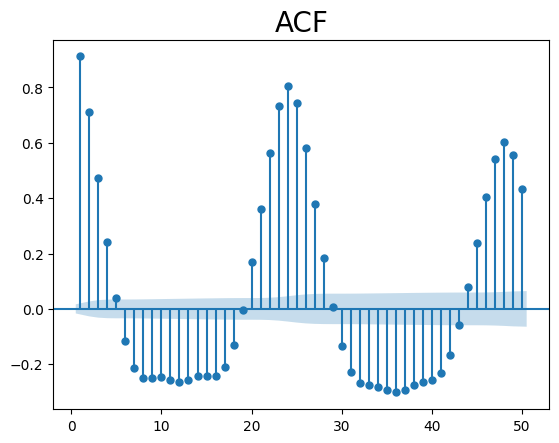

In [ ]:
# ACF
sgt.plot_acf(train_set['order_count'], lags=50, alpha=0.05, zero=False)
plt.title("ACF", size=20)
plt.autoscale(enable=True, axis='y')
plt.show()

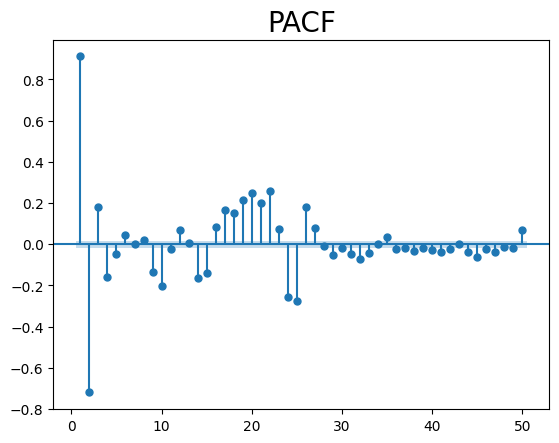

In [ ]:
# PCF
sgt.plot_pacf(train_set['order_count'], lags=50, alpha=0.05, zero=False, method = ('ols'))
plt.title("PACF", size=20)
plt.autoscale(enable=True, axis='y')
plt.show()

# ARIMA FIT

In [ ]:
# ARIMA
model_ar = ARIMA(train_set['order_count'], order = (2,0,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            order_count   No. Observations:                14035
Model:                 ARIMA(2, 0, 0)   Log Likelihood             -132814.829
Date:                Wed, 30 Apr 2025   AIC                         265637.658
Time:                        16:02:48   BIC                         265667.855
Sample:                             0   HQIC                        265647.710
                              - 14035                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.686e+04    188.816    142.243      0.000    2.65e+04    2.72e+04
ar.L1          1.5687      0.003    544.047      0.000       1.563       1.574
ar.L2         -0.7204      0.003   -227.372      0.000      -0.727      -0.714
sigma2      9.702e+06      0.097   1.01e+08      0.000     9.7e+06     9.7e+06
===================================================================================
Ljung-Box (L1) (Q):                 238.33   Jarque-Bera (JB):            154321.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+22. Standard errors may be unstable.
"""

In [ ]:
# ARIMA
model_ar = ARIMA(train_set['order_count'], order = (7,0,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            order_count   No. Observations:                14035
Model:                 ARIMA(7, 0, 0)   Log Likelihood             -132365.939
Date:                Wed, 30 Apr 2025   AIC                         264749.878
Time:                        04:53:04   BIC                         264817.822
Sample:                             0   HQIC                        264772.494
                              - 14035                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.686e+04    201.911    133.018      0.000    2.65e+04    2.73e+04
ar.L1          1.7226      0.003    557.461      0.000       1.717       1.729
ar.L2         -1.1400      0.004   -254.493      0.000      -1.149      -1.131
ar.L3          0.3793      0.012     32.815      0.000       0.357       0.402
ar.L4         -0.0248      0.018     -1.397      0.163      -0.060       0.010
ar.L5         -0.1258      0.019     -6.753      0.000      -0.162      -0.089
ar.L6          0.0427      0.016      2.720      0.007       0.012       0.073
ar.L7          0.0023      0.009      0.252      0.801      -0.015       0.020
sigma2        9.1e+06      0.087   1.05e+08      0.000     9.1e+06     9.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            442499.63
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.36e+22. Standard errors may be unstable.
"""

# ARMA

In [ ]:
# ARIMA
model_arma = ARIMA(train_set['order_count'], order = (3,0,3))
results_arma = model_arma.fit()
results_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            order_count   No. Observations:                14035
Model:                 ARIMA(3, 0, 3)   Log Likelihood             -132352.684
Date:                Wed, 30 Apr 2025   AIC                         264721.368
Time:                        04:53:44   BIC                         264781.762
Sample:                             0   HQIC                        264741.471
                              - 14035                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.686e+04    172.289    155.888      0.000    2.65e+04    2.72e+04
ar.L1          1.5555      0.062     25.026      0.000       1.434       1.677
ar.L2         -0.5589      0.098     -5.707      0.000      -0.751      -0.367
ar.L3         -0.1032      0.045     -2.276      0.023      -0.192      -0.014
ma.L1          0.1659      0.062      2.698      0.007       0.045       0.286
ma.L2         -0.3094      0.018    -17.001      0.000      -0.345      -0.274
ma.L3         -0.2372      0.015    -15.350      0.000      -0.268      -0.207
sigma2      9.165e+06      0.089   1.03e+08      0.000    9.17e+06    9.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            460857.67
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.78e+22. Standard errors may be unstable.
"""

In [ ]:
# ARIMA
model_arma = ARIMA(train_set['order_count'], order = (4,0,4))
results_arma = model_arma.fit()
results_arma.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            order_count   No. Observations:                14035
Model:                 ARIMA(4, 0, 4)   Log Likelihood             -131657.393
Date:                Wed, 30 Apr 2025   AIC                         263334.786
Time:                        14:13:51   BIC                         263410.279
Sample:                             0   HQIC                        263359.915
                              - 14035                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.686e+04    222.297    120.819      0.000    2.64e+04    2.73e+04
ar.L1          2.1577      0.009    233.727      0.000       2.140       2.176
ar.L2         -2.6068      0.013   -198.844      0.000      -2.633      -2.581
ar.L3          2.0253      0.014    149.937      0.000       1.999       2.052
ar.L4         -0.7627      0.008    -95.959      0.000      -0.778      -0.747
ma.L1         -0.4533      0.010    -44.209      0.000      -0.473      -0.433
ma.L2          0.8390      0.008    105.825      0.000       0.824       0.855
ma.L3          0.0900      0.006     14.077      0.000       0.077       0.103
ma.L4         -0.1029      0.013     -8.208      0.000      -0.127      -0.078
sigma2      9.078e+06      0.031   2.93e+08      0.000    9.08e+06    9.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.22   Jarque-Bera (JB):            552374.78
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.81e+23. Standard errors may be unstable.
"""

# SARIMA

In [ ]:
# ARIMA
model_sarima = SARIMAX(train_set['order_count'], order = (4,0,4), seasonal_order = (1, 0, 0, 24))
results_sarima = model_sarima.fit()
results_sarima.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       order_count   No. Observations:                14035
Model:             ARIMA(4, 0, 4)x(1, 0, [], 24)   Log Likelihood             -129742.113
Date:                           Thu, 27 Mar 2025   AIC                         259506.227
Time:                                   08:02:09   BIC                         259589.269
Sample:                                        0   HQIC                        259533.869
                                         - 14035                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.686e+04    542.227     49.532      0.000    2.58e+04    2.79e+04
ar.L1          2.0679      0.024     87.824      0.000       2.022       2.114
ar.L2         -2.4322      0.036    -68.424      0.000      -2.502      -2.363
ar.L3          1.8382      0.036     51.704      0.000       1.769       1.908
ar.L4         -0.6452      0.019    -34.035      0.000      -0.682      -0.608
ma.L1         -0.6458      0.025    -26.078      0.000      -0.694      -0.597
ma.L2          0.9126      0.015     59.926      0.000       0.883       0.942
ma.L3         -0.1080      0.017     -6.452      0.000      -0.141      -0.075
ma.L4         -0.0876      0.021     -4.192      0.000      -0.129      -0.047
ar.S.L24       0.6190      0.004    147.096      0.000       0.611       0.627
sigma2      9.076e+06      0.009   9.65e+08      0.000    9.08e+06    9.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):            945980.53
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.49e+24. Standard errors may be unstable.
"""

In [ ]:
# ARIMA
model_sarima = SARIMAX(train_set['order_count'], order = (3,0,3), seasonal_order = (2, 0, 0, 24))
results_sarima = model_sarima.fit()
results_sarima.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       order_count   No. Observations:                14035
Model:             ARIMA(3, 0, 3)x(2, 0, [], 24)   Log Likelihood             -129739.912
Date:                           Thu, 27 Mar 2025   AIC                         259499.825
Time:                                   08:40:52   BIC                         259575.318
Sample:                                        0   HQIC                        259524.954
                                         - 14035                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.686e+04    832.552     32.260      0.000    2.52e+04    2.85e+04
ar.L1          2.4231      0.027     88.703      0.000       2.370       2.477
ar.L2         -2.1684      0.044    -49.811      0.000      -2.254      -2.083
ar.L3          0.6952      0.020     35.055      0.000       0.656       0.734
ma.L1         -1.0665      0.027    -39.546      0.000      -1.119      -1.014
ma.L2          0.1331      0.013     10.411      0.000       0.108       0.158
ma.L3          0.3035      0.014     21.613      0.000       0.276       0.331
ar.S.L24       0.5811      0.004    142.436      0.000       0.573       0.589
ar.S.L48       0.1353      0.009     15.630      0.000       0.118       0.152
sigma2      8.902e+06      0.309   2.88e+07      0.000     8.9e+06     8.9e+06
===================================================================================
Ljung-Box (L1) (Q):                  51.32   Jarque-Bera (JB):            641798.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.23e+22. Standard errors may be unstable.
"""

In [ ]:
# ARIMA
model_sarima = SARIMAX(train_set['order_count'], order = (4,0,4), seasonal_order = (2, 0, 0, 24))
results_sarima = model_sarima.fit()
results_sarima.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       order_count   No. Observations:                14035
Model:             ARIMA(4, 0, 4)x(2, 0, [], 24)   Log Likelihood             -129704.156
Date:                           Wed, 30 Apr 2025   AIC                         259432.312
Time:                                   14:47:18   BIC                         259522.904
Sample:                                        0   HQIC                        259462.467
                                         - 14035                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.686e+04    640.727     41.918      0.000    2.56e+04    2.81e+04
ar.L1          2.0809      0.027     76.758      0.000       2.028       2.134
ar.L2         -2.4408      0.043    -56.556      0.000      -2.525      -2.356
ar.L3          1.7893      0.042     42.970      0.000       1.708       1.871
ar.L4         -0.6074      0.021    -29.432      0.000      -0.648      -0.567
ma.L1         -0.6527      0.029    -22.688      0.000      -0.709      -0.596
ma.L2          0.8937      0.019     47.395      0.000       0.857       0.931
ma.L3         -0.0607      0.017     -3.555      0.000      -0.094      -0.027
ma.L4         -0.0479      0.021     -2.278      0.023      -0.089      -0.007
ar.S.L24       0.5643      0.005    122.096      0.000       0.555       0.573
ar.S.L48       0.1030      0.009     11.012      0.000       0.085       0.121
sigma2      9.077e+06      0.155   5.87e+07      0.000    9.08e+06    9.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):            917407.84
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.63e+22. Standard errors may be unstable.
"""

# SARIMAX BEST

In [ ]:
model_sa_0 = SARIMAX(train_set['order_count'],
                order=(1,1,1),
                seasonal_order=(1,1,1,24))
modelsa0_fit = model_sa_0.fit()
modelsa0_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        order_count   No. Observations:                14035
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -128129.471
Date:                            Thu, 01 May 2025   AIC                         256268.941
Time:                                    03:52:15   BIC                         256306.679
Sample:                                         0   HQIC                        256281.504
                                          - 14035                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2180      0.011     19.122      0.000       0.196       0.240
ma.L1          0.2792      0.009     31.522      0.000       0.262       0.297
ar.S.L24       0.2915      0.003     87.996      0.000       0.285       0.298
ma.S.L24      -1.0000      0.005   -215.045      0.000      -1.009      -0.991
sigma2      5.086e+06   9.08e-10    5.6e+15      0.000    5.09e+06    5.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):           1353254.10
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.81e+29. Standard errors may be unstable.
"""

In [ ]:
model_sa = SARIMAX(train_set['order_count'],
                order=(6,0,0),
                seasonal_order=(1,1,1,24))
modelsa_fit = model_sa.fit()
modelsa_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          order_count   No. Observations:                14035
Model:             SARIMAX(6, 0, 0)x(1, 1, [1], 24)   Log Likelihood             -127416.943
Date:                              Thu, 01 May 2025   AIC                         254851.886
Time:                                      03:45:55   BIC                         254919.815
Sample:                                           0   HQIC                        254874.500
                                            - 14035                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3884      0.004    369.295      0.000       1.381       1.396
ar.L2         -0.5916      0.004   -141.387      0.000      -0.600      -0.583
ar.L3          0.1121      0.010     11.426      0.000       0.093       0.131
ar.L4         -0.0404      0.012     -3.257      0.001      -0.065      -0.016
ar.L5         -0.0527      0.011     -4.626      0.000      -0.075      -0.030
ar.L6          0.0457      0.006      7.106      0.000       0.033       0.058
ar.S.L24       0.2757      0.004     77.711      0.000       0.269       0.283
ma.S.L24      -0.9867      0.001   -668.337      0.000      -0.990      -0.984
sigma2      4.587e+06   2.08e+04    220.813      0.000    4.55e+06    4.63e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):           1621988.08
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.33
Prob(H) (two-sided):                  0.04   Kurtosis:                        55.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SARIMAX

In [ ]:
exog_train_set_drop = exog_train_set.drop(columns=['is_holiday','hour','dayofweek','day'])

In [ ]:
model_sax_1 = SARIMAX(train_set['order_count'],
                exog=exog_train_set_drop,
                order=(1,1,1),
                seasonal_order=(1,1,1,24))
modelsax1_fit = model_sax_1.fit()
modelsax1_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        order_count   No. Observations:                14035
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -128127.582
Date:                            Thu, 01 May 2025   AIC                         256269.164
Time:                                    03:34:59   BIC                         256321.997
Sample:                                         0   HQIC                        256286.752
                                          - 14035                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend  1004.5397    153.496      6.544      0.000     703.693    1305.387
month      -1302.5174     44.726    -29.122      0.000   -1390.179   -1214.856
ar.L1          0.2131      0.011     18.723      0.000       0.191       0.235
ma.L1          0.2801      0.009     31.499      0.000       0.263       0.297
ar.S.L24       0.2932      0.003     88.641      0.000       0.287       0.300
ma.S.L24      -0.9999      0.005   -215.004      0.000      -1.009      -0.991
sigma2      5.084e+06      0.007    7.1e+08      0.000    5.08e+06    5.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):           1285590.27
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.44e+24. Standard errors may be unstable.
"""

In [ ]:
model_sax_2 = SARIMAX(train_set['order_count'],
                exog=exog_train_set_drop,
                order=(6,0,0),
                seasonal_order=(1,1,1,24))
modelsax2_fit = model_sax_2.fit()
modelsax2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          order_count   No. Observations:                14035
Model:             SARIMAX(6, 0, 0)x(1, 1, [1], 24)   Log Likelihood             -127563.392
Date:                              Thu, 01 May 2025   AIC                         255148.784
Time:                                      03:40:27   BIC                         255231.808
Sample:                                           0   HQIC                        255176.422
                                            - 14035                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend  3148.9939     96.086     32.773      0.000    2960.669    3337.319
month        -71.2504     19.066     -3.737      0.000    -108.618     -33.882
ar.L1          1.3501      0.004    363.150      0.000       1.343       1.357
ar.L2         -0.5519      0.005   -121.620      0.000      -0.561      -0.543
ar.L3          0.1052      0.010     10.483      0.000       0.085       0.125
ar.L4         -0.0330      0.012     -2.651      0.008      -0.057      -0.009
ar.L5         -0.0701      0.011     -6.164      0.000      -0.092      -0.048
ar.L6          0.0407      0.007      6.037      0.000       0.027       0.054
ar.S.L24       0.2899      0.003     82.929      0.000       0.283       0.297
ma.S.L24      -1.0000      0.005   -211.640      0.000      -1.009      -0.991
sigma2      4.665e+06      0.001   4.29e+09      0.000    4.66e+06    4.66e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):           1181944.13
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.35
Prob(H) (two-sided):                  0.02   Kurtosis:                        47.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.81e+27. Standard errors may be unstable.
"""

In [ ]:
'''
plt.figure(figsize=(12, 6))
plt.plot(train_set.head(100).index, train_set['order_count'].head(100), label="Actual")
plt.plot(train_set.head(100).index, results_ar.fittedvalues.head(100), color='white', label="Fitted")
plt.title("ARIMA Model - Actual vs. Fitted Values")
plt.legend()
plt.show()
'''

'\nplt.figure(figsize=(12, 6))\nplt.plot(train_set.head(100).index, train_set[\'order_count\'].head(100), label="Actual")\nplt.plot(train_set.head(100).index, results_ar.fittedvalues.head(100), color=\'white\', label="Fitted")\nplt.title("ARIMA Model - Actual vs. Fitted Values")\nplt.legend()\nplt.show()\n'

In [ ]:
'''
plt.figure(figsize=(12, 6))
plt.plot(train_set.head(100).index, train_set['order_count'].head(100), label="Actual")
plt.plot(train_set.head(100).index, results_arma.fittedvalues.head(100), color='white', label="Fitted")
plt.title("ARIMA Model - Actual vs. Fitted Values")
plt.legend()
plt.show()
'''

'\nplt.figure(figsize=(12, 6))\nplt.plot(train_set.head(100).index, train_set[\'order_count\'].head(100), label="Actual")\nplt.plot(train_set.head(100).index, results_arma.fittedvalues.head(100), color=\'white\', label="Fitted")\nplt.title("ARIMA Model - Actual vs. Fitted Values")\nplt.legend()\nplt.show()\n'

#Proper Plots

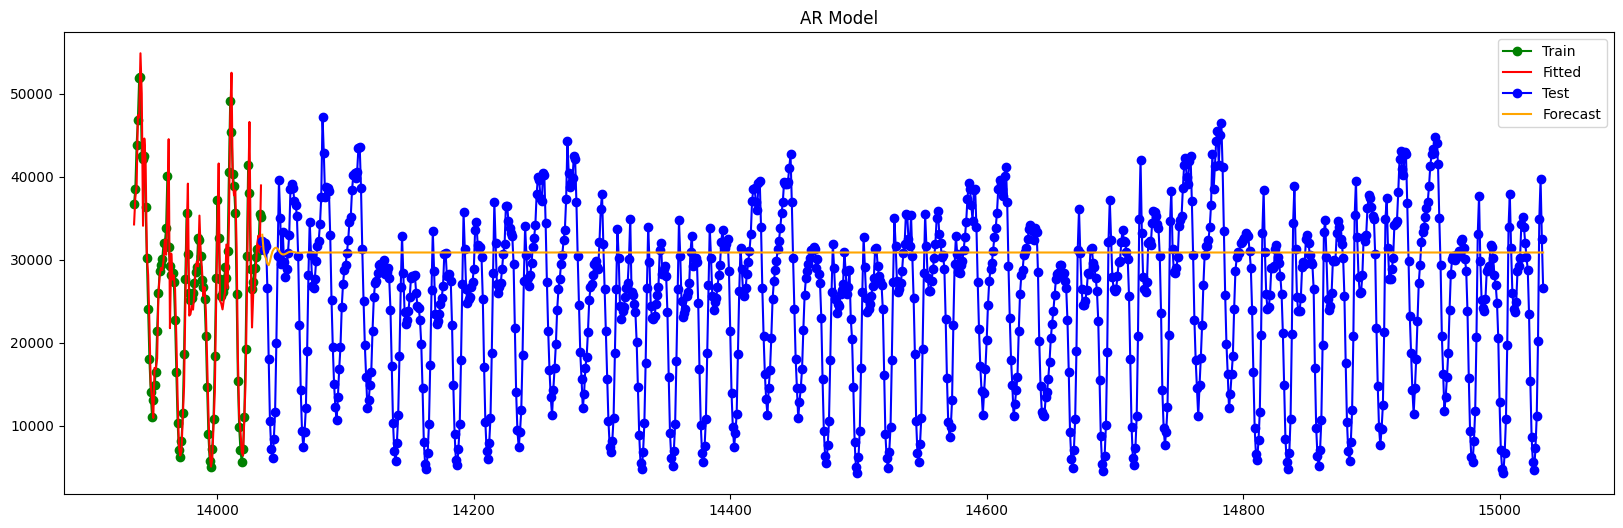

In [ ]:
train_plots = 100
no_plots = 1000
plt.figure(figsize=(20, 6))
plt.plot(train_set.tail(train_plots).index, train_set['order_count'].tail(train_plots), label="Train", marker='o', color='green')
plt.plot(train_set.tail(train_plots).index, results_ar.fittedvalues.tail(train_plots), label="Fitted", color='red')
plt.plot(test_set.head(no_plots).index, test_set['order_count'].head(no_plots), color='blue', label="Test", marker='o')
plt.plot(test_set.head(no_plots).index, results_ar.forecast(steps=no_plots), color='orange', label="Forecast")
plt.title("AR Model")
plt.legend()
plt.show()

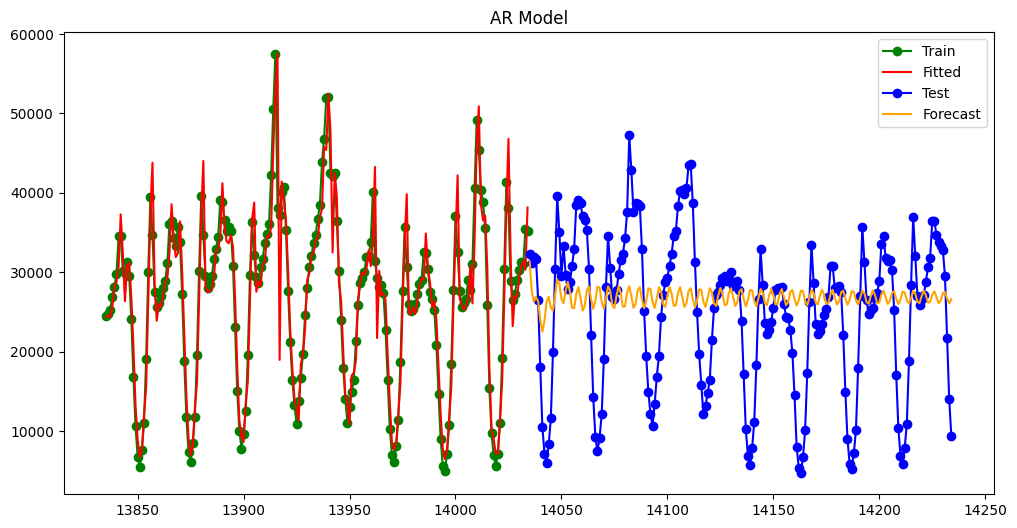

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_set.tail(200).index, train_set['order_count'].tail(200), label="Train", marker='o', color='green')
plt.plot(train_set.tail(200).index, results_ar.fittedvalues.tail(200), label="Fitted", color='red')
plt.plot(test_set.head(200).index, test_set['order_count'].head(200), color='blue', label="Test", marker='o')
plt.plot(test_set.head(200).index, results_arma.forecast(steps=200), color='orange', label="Forecast")
plt.title("AR Model")
plt.legend()
plt.show()

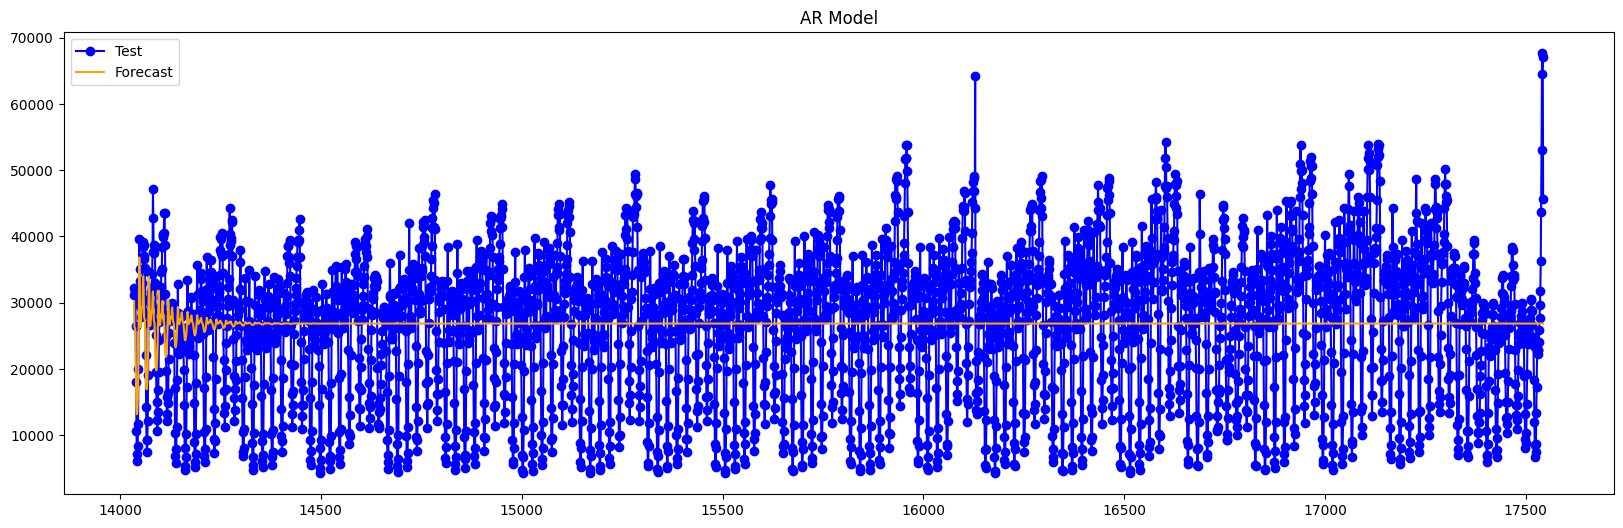

In [ ]:
plt.figure(figsize=(20, 6))
#plt.plot(train_set.tail(200).index, train_set['order_count'].tail(200), label="Train", marker='o', color='green')
#plt.plot(train_set.tail(200).index, results_sarima.fittedvalues.tail(200), label="Fitted", color='red')
plt.plot(test_set.index, test_set['order_count'], color='blue', label="Test", marker='o')
plt.plot(test_set.index, results_sarima.forecast(steps=test_set.shape[0]), color='orange', label="Forecast")
plt.title("AR Model")
plt.legend()
plt.show()

# SARIMAX 1 2

In [ ]:
test_all = test_set.shape[0]

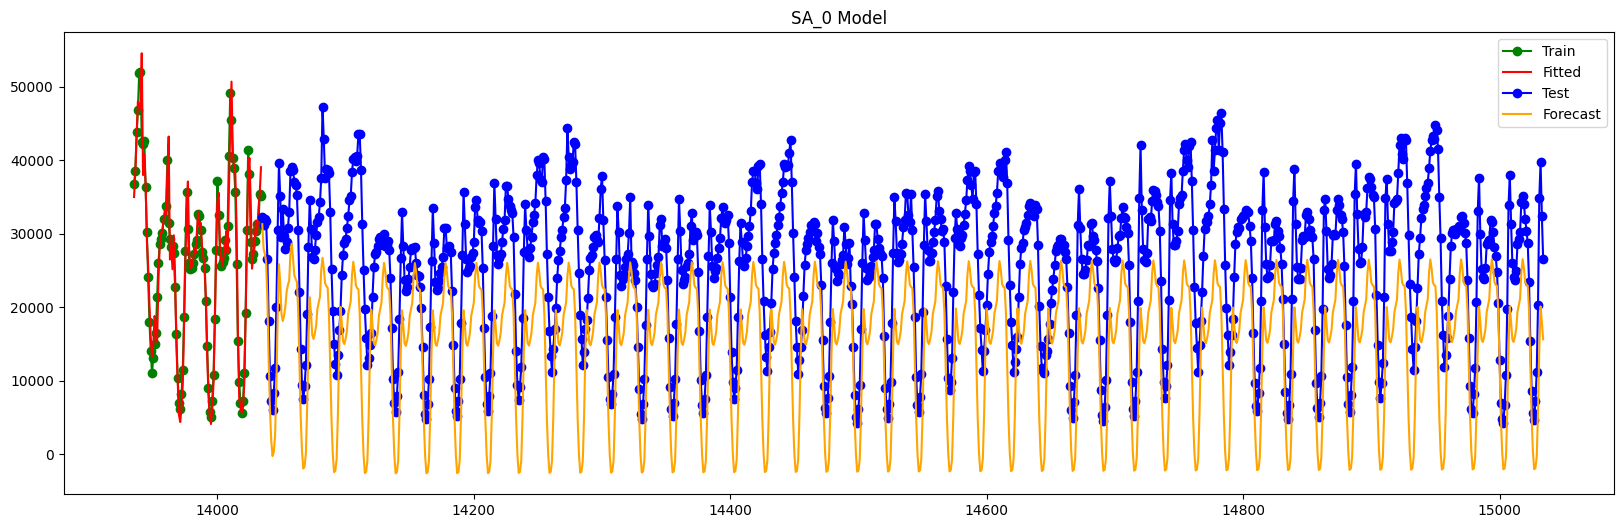

MSE: 169814735.11256835
RMSE: 13031.298289601398


In [ ]:
train_plots = 100
no_plots = 1000
plt.figure(figsize=(20, 6))
plt.plot(train_set.tail(train_plots).index, train_set['order_count'].tail(train_plots), label="Train", marker='o', color='green')
plt.plot(train_set.tail(train_plots).index, modelsa0_fit.fittedvalues.tail(train_plots), label="Fitted", color='red')
plt.plot(test_set.head(no_plots).index, test_set['order_count'].head(no_plots), color='blue', label="Test", marker='o')
plt.plot(test_set.head(no_plots).index, modelsa0_fit.forecast(steps=no_plots), color='orange', label="Forecast")
plt.title("SA_0 Model")
plt.legend()
plt.show()

#MSE AND RMSE
mse = mean_squared_error(test_set['order_count'], modelsa0_fit.forecast(steps=test_all))
rmse = root_mean_squared_error(test_set['order_count'], modelsa0_fit.forecast(steps=test_all))
print("MSE:", mse)
print("RMSE:", rmse)

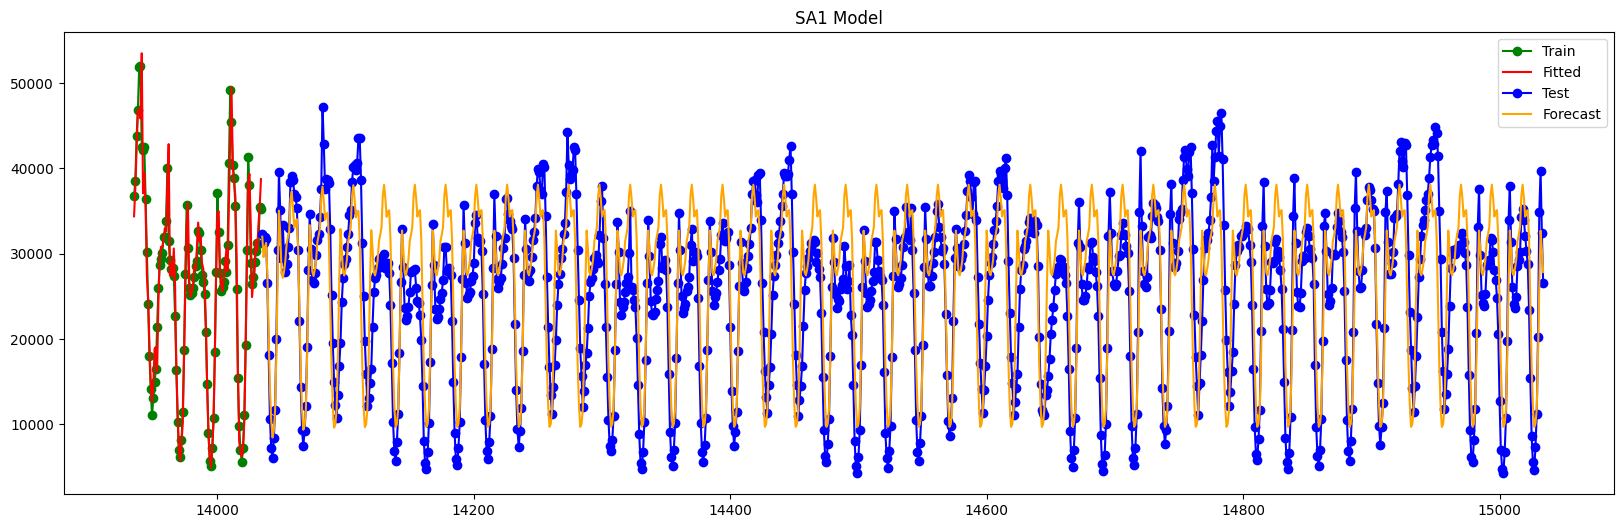

MSE: 39546180.82001698
RMSE: 6288.575420555675


In [ ]:
train_plots = 100
no_plots = 1000
plt.figure(figsize=(20, 6))
plt.plot(train_set.tail(train_plots).index, train_set['order_count'].tail(train_plots), label="Train", marker='o', color='green')
plt.plot(train_set.tail(train_plots).index, modelsa_fit.fittedvalues.tail(train_plots), label="Fitted", color='red')
plt.plot(test_set.head(no_plots).index, test_set['order_count'].head(no_plots), color='blue', label="Test", marker='o')
plt.plot(test_set.head(no_plots).index, modelsa_fit.forecast(steps=no_plots), color='orange', label="Forecast")
plt.title("SA1 Model")
plt.legend()
plt.show()

#MSE AND RMSE
mse = mean_squared_error(test_set['order_count'], modelsa_fit.forecast(steps=test_all))
rmse = root_mean_squared_error(test_set['order_count'], modelsa_fit.forecast(steps=test_all))
print("MSE:", mse)
print("RMSE:", rmse)

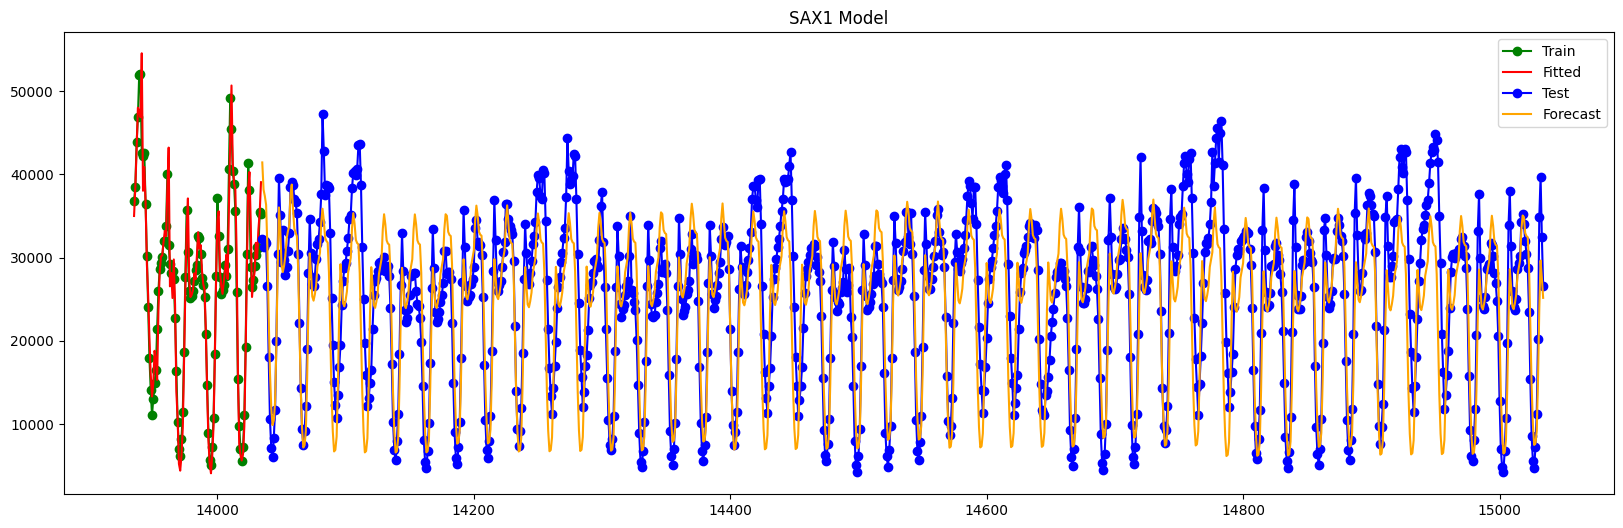

MSE: 52843437.54169528
RMSE: 7269.349182815149


In [ ]:
train_plots = 100
no_plots = 1000
plt.figure(figsize=(20, 6))
plt.plot(train_set.tail(train_plots).index, train_set['order_count'].tail(train_plots), label="Train", marker='o', color='green')
plt.plot(train_set.tail(train_plots).index, modelsax1_fit.fittedvalues.tail(train_plots), label="Fitted", color='red')
plt.plot(test_set.head(no_plots).index, test_set['order_count'].head(no_plots), color='blue', label="Test", marker='o')
plt.plot(test_set.head(no_plots).index, modelsax1_fit.forecast(steps=no_plots,exog=exog_train_set_drop.head(no_plots)), color='orange', label="Forecast")
plt.title("SAX1 Model")
plt.legend()
plt.show()



#MSE AND RMSE
mse = mean_squared_error(test_set['order_count'], modelsax1_fit.forecast(steps=test_all,exog=exog_train_set_drop.head(test_all)))
rmse = root_mean_squared_error(test_set['order_count'], modelsax1_fit.forecast(steps=test_all,exog=exog_train_set_drop.head(test_all)))
print("MSE:", mse)
print("RMSE:", rmse)

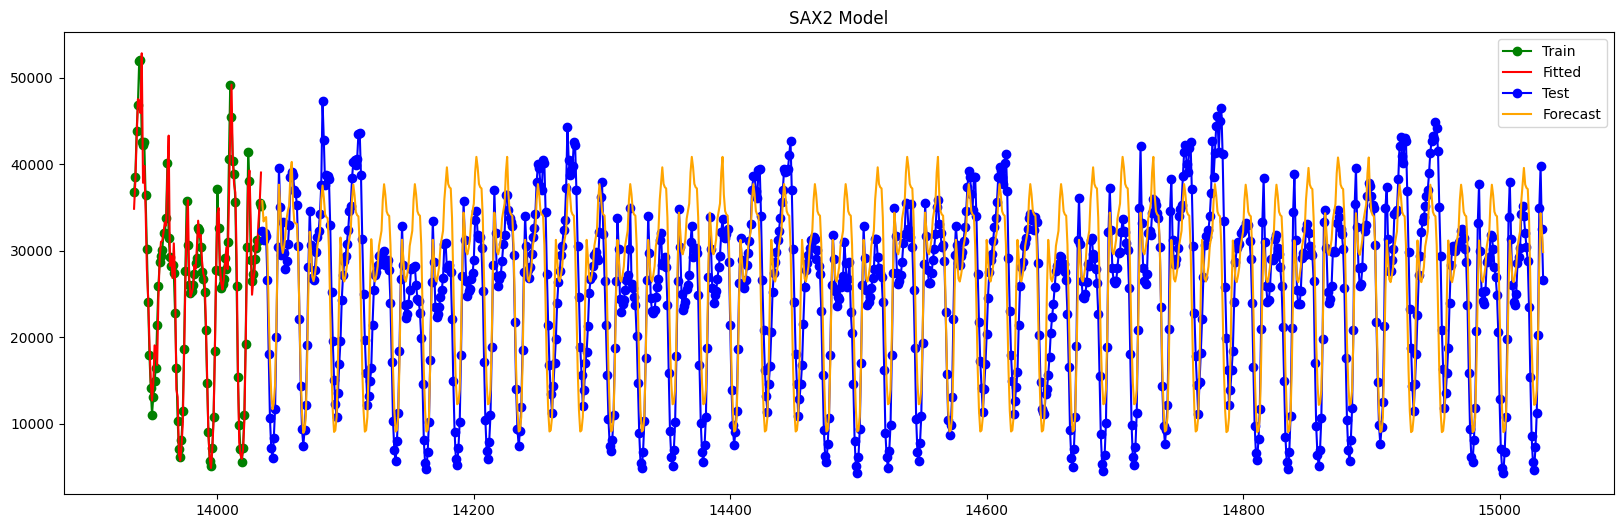

MSE: 43722993.64963786
RMSE: 6612.3364743211505


In [ ]:
train_plots = 100
no_plots = 1000
plt.figure(figsize=(20, 6))
plt.plot(train_set.tail(train_plots).index, train_set['order_count'].tail(train_plots), label="Train", marker='o', color='green')
plt.plot(train_set.tail(train_plots).index, modelsax2_fit.fittedvalues.tail(train_plots), label="Fitted", color='red')
plt.plot(test_set.head(no_plots).index, test_set['order_count'].head(no_plots), color='blue', label="Test", marker='o')
plt.plot(test_set.head(no_plots).index, modelsax2_fit.forecast(steps=no_plots,exog=exog_train_set_drop.head(no_plots)), color='orange', label="Forecast")
plt.title("SAX2 Model")
plt.legend()
plt.show()

#MSE AND RMSE
mse = mean_squared_error(test_set['order_count'], modelsax2_fit.forecast(steps=test_all,exog=exog_train_set_drop.head(test_all)))
rmse = root_mean_squared_error(test_set['order_count'], modelsax2_fit.forecast(steps=test_all,exog=exog_train_set_drop.head(test_all)))
print("MSE:", mse)
print("RMSE:", rmse)

# Benchmark

In [ ]:
test_set['order_count_benchmark'] = test_set['order_count'].shift(1)
test_set.loc[test_set.index[0], 'order_count_benchmark'] = train_set['order_count'].iloc[-1]

<ipython-input-40-2b6044c38bba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['order_count_benchmark'] = test_set['order_count'].shift(1)


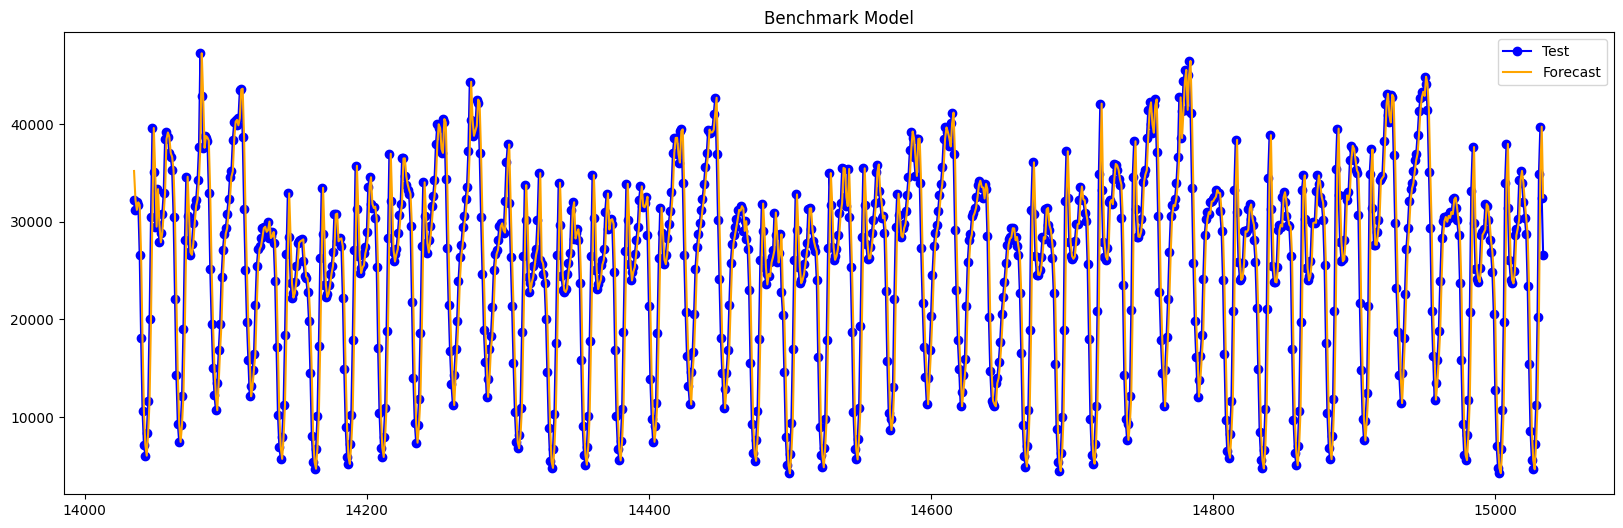

MSE: 19920617.14847535
RMSE: 4463.251858059923


In [ ]:
train_plots = 100
no_plots = 1000
plt.figure(figsize=(20, 6))
#plt.plot(train_set.tail(train_plots).index, train_set['order_count'].tail(train_plots), label="Train", marker='o', color='green')
#plt.plot(train_set.tail(train_plots).index, modelsax2_fit.fittedvalues.tail(train_plots), label="Fitted", color='red')
plt.plot(test_set.head(no_plots).index, test_set['order_count'].head(no_plots), color='blue', label="Test", marker='o')
plt.plot(test_set.head(no_plots).index, test_set['order_count_benchmark'].head(no_plots), color='orange', label="Forecast")
#plt.plot(test_set.head(no_plots).index, test_set['order_count'].head(no_plots), color='orange', label="Forecast")
plt.title("Benchmark Model")
plt.legend()
plt.show()

#MSE AND RMSE
mse = mean_squared_error(test_set['order_count'], test_set['order_count_benchmark'])
rmse = root_mean_squared_error(test_set['order_count'], test_set['order_count_benchmark'])
print("MSE:", mse)
print("RMSE:", rmse)


#Explore the seasonal


In [ ]:
sts = small_train_set

In [ ]:
sts['datetime_hour'] = pd.to_datetime(sts['datetime_hour'])


<ipython-input-81-f8b50c131fd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sts['datetime_hour'] = pd.to_datetime(sts['datetime_hour'])


In [ ]:
sts['hour'] = sts['datetime_hour'].dt.hour

<ipython-input-82-8bb7eaae9a11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sts['hour'] = sts['datetime_hour'].dt.hour


In [ ]:
df_dict = {key: group for key, group in sts.groupby('hour')}

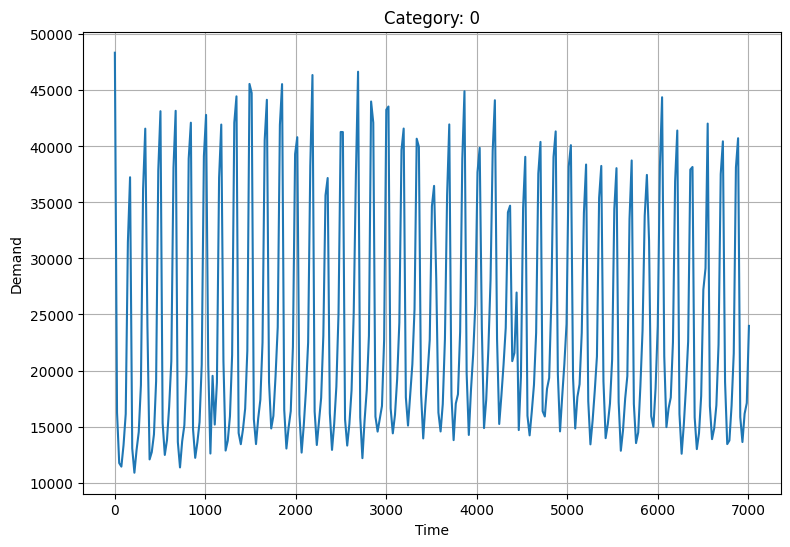

Augmented Dickey Fuller p-value: 0.008672
Stationary


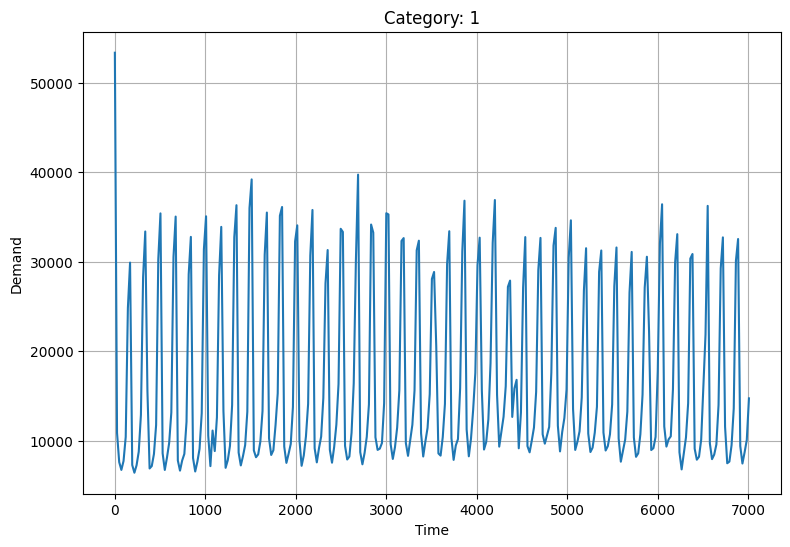

Augmented Dickey Fuller p-value: 0.020233
Stationary


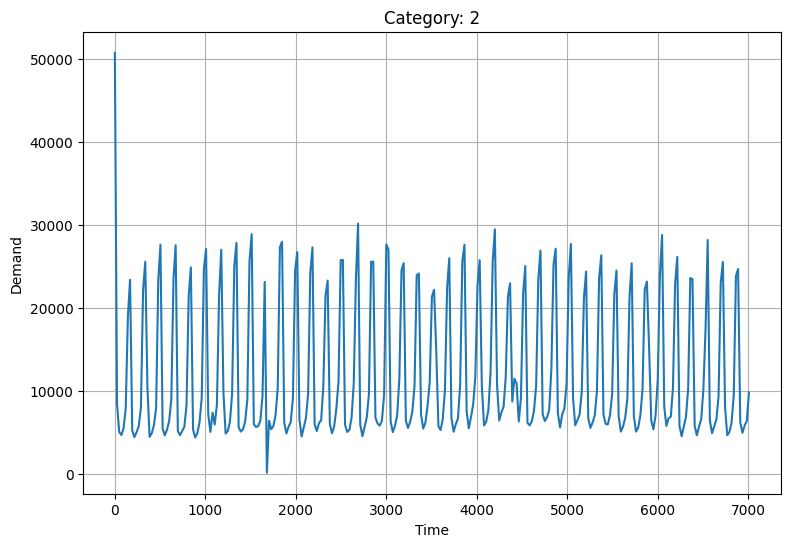

Augmented Dickey Fuller p-value: 0.020898
Stationary


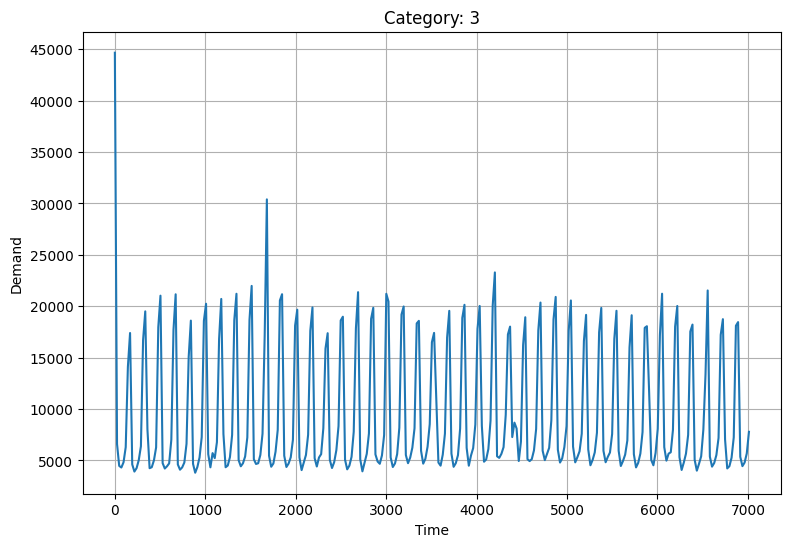

Augmented Dickey Fuller p-value: 0.008590
Stationary


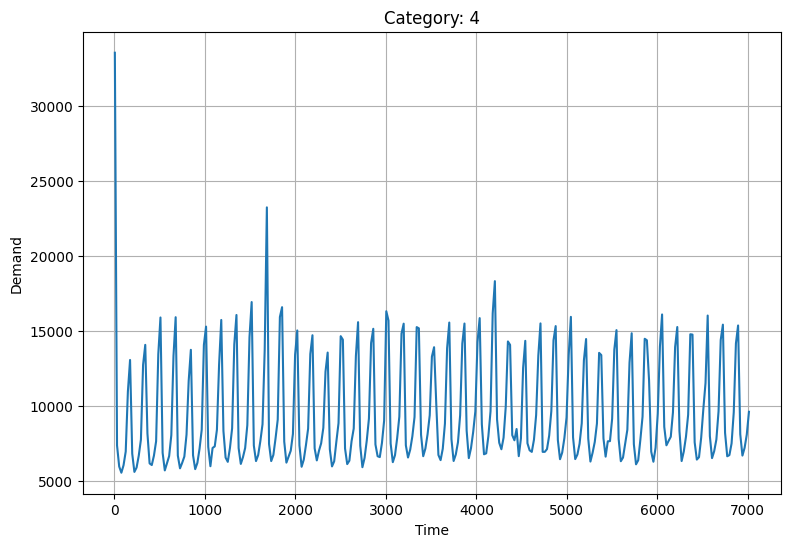

Augmented Dickey Fuller p-value: 0.018476
Stationary


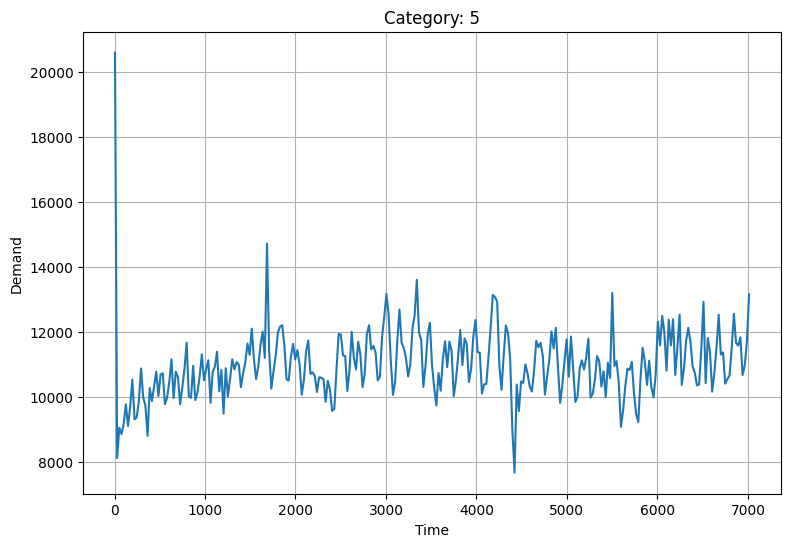

Augmented Dickey Fuller p-value: 0.005548
Stationary


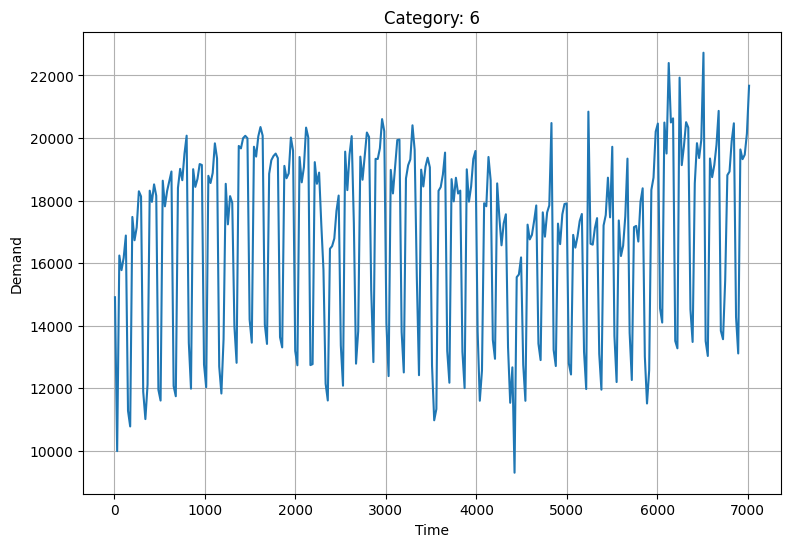

Augmented Dickey Fuller p-value: 0.028103
Stationary


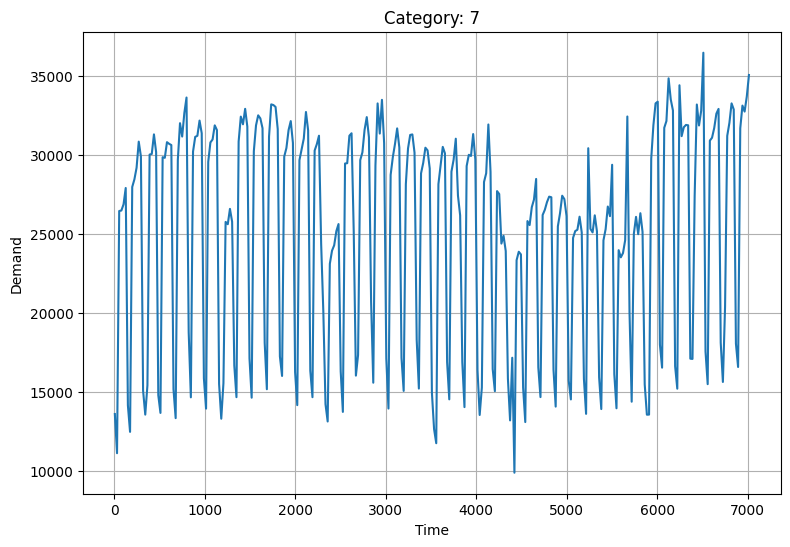

Augmented Dickey Fuller p-value: 0.068299
Not stationary


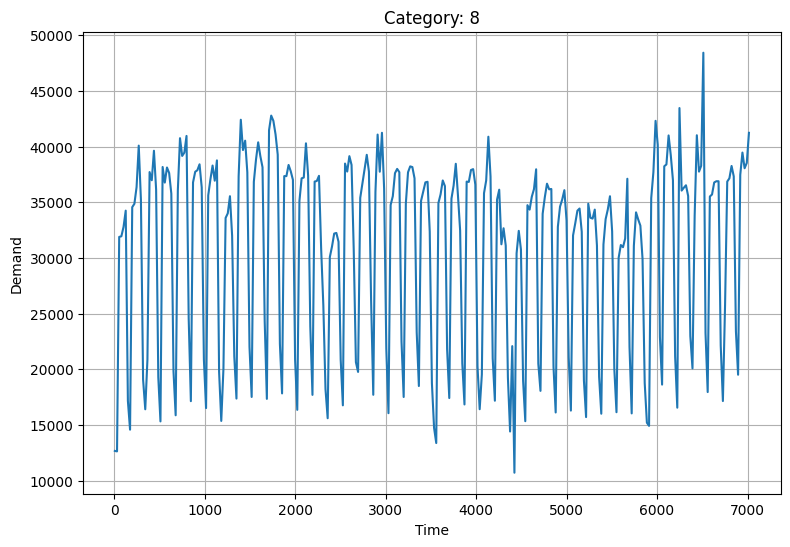

Augmented Dickey Fuller p-value: 0.013077
Stationary


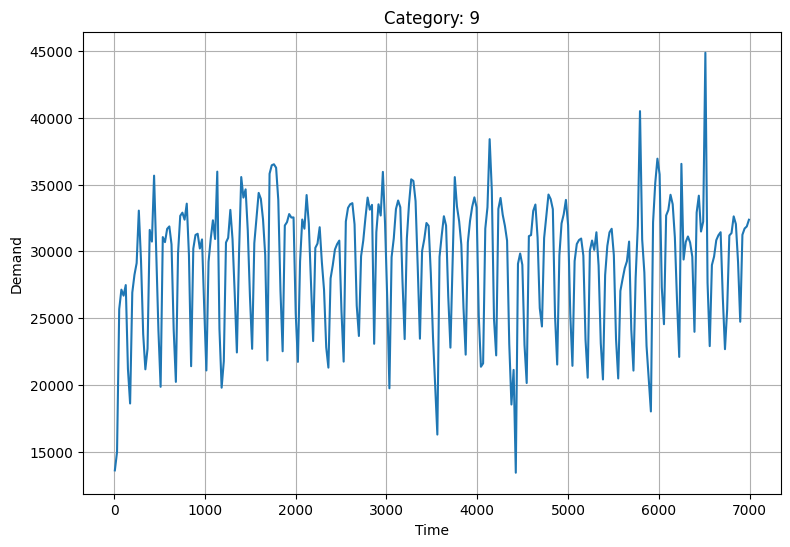

Augmented Dickey Fuller p-value: 0.000817
Stationary


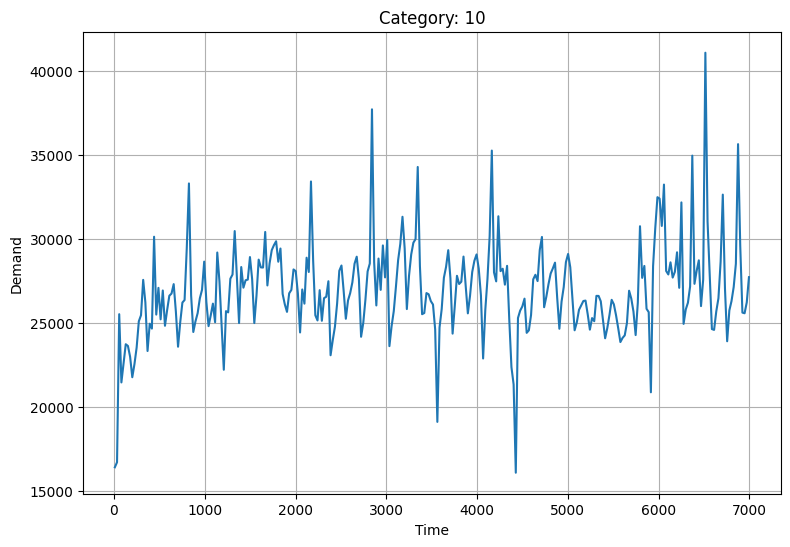

Augmented Dickey Fuller p-value: 0.002751
Stationary


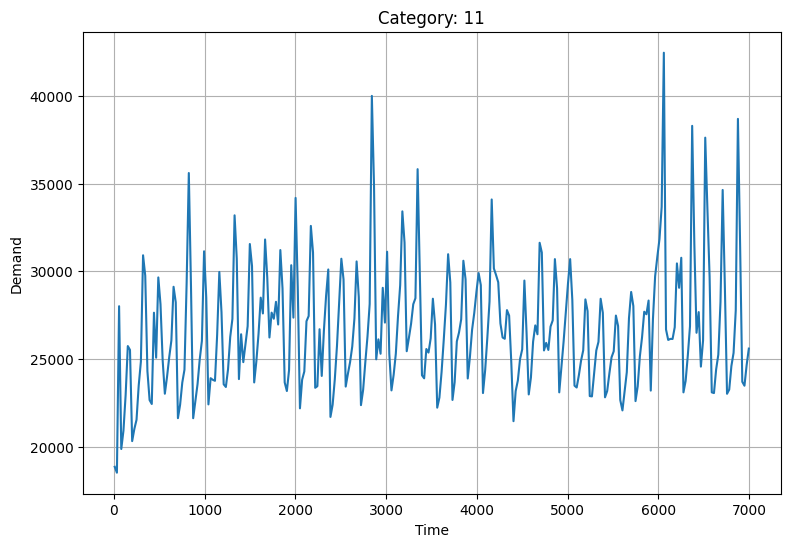

Augmented Dickey Fuller p-value: 0.009681
Stationary


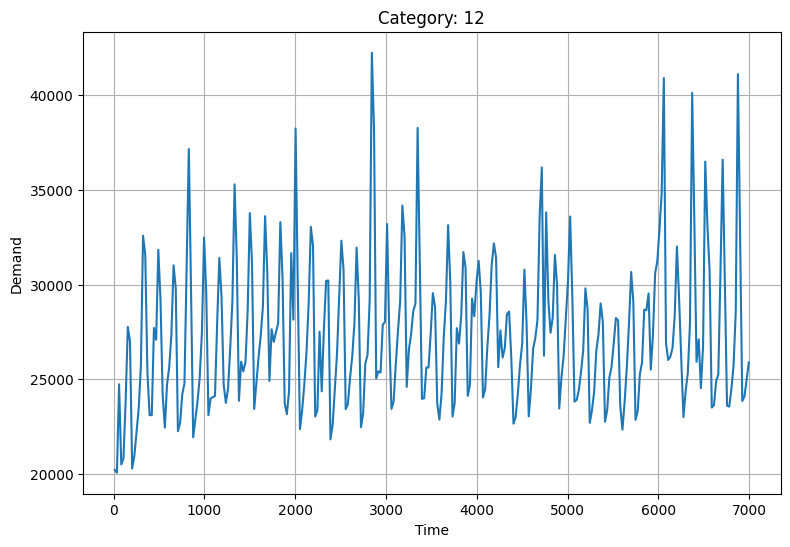

Augmented Dickey Fuller p-value: 0.001193
Stationary


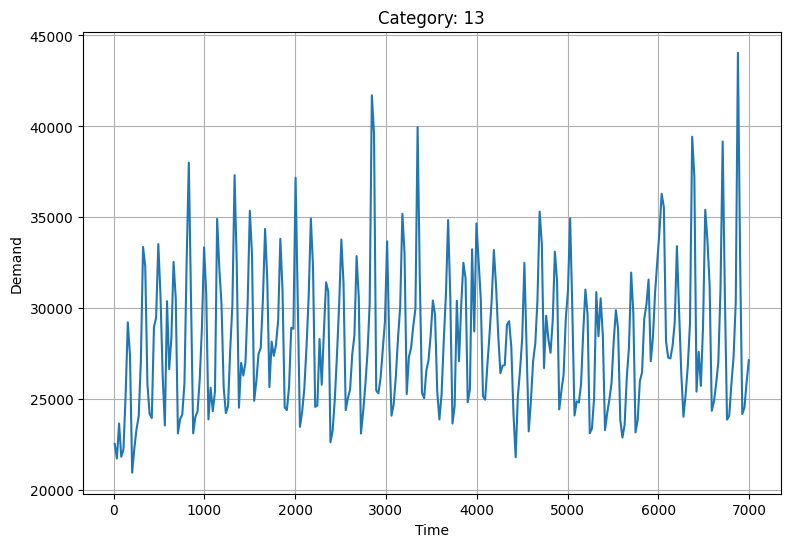

Augmented Dickey Fuller p-value: 0.002864
Stationary


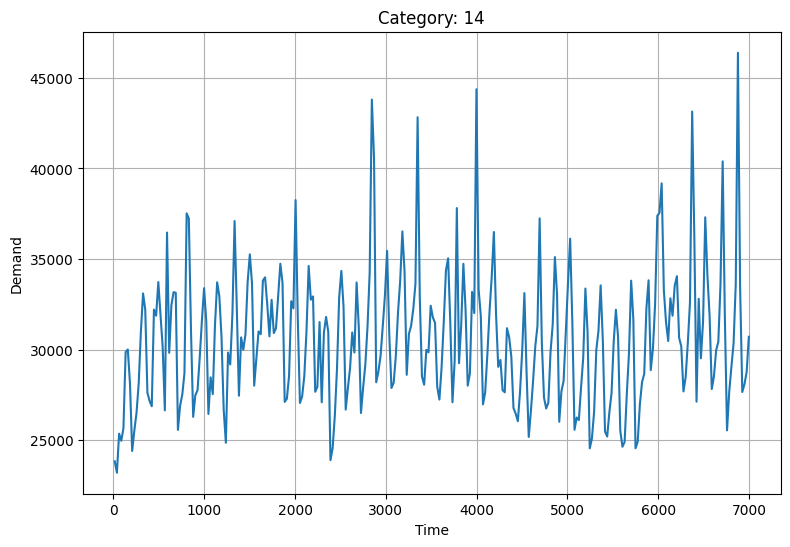

Augmented Dickey Fuller p-value: 0.018004
Stationary


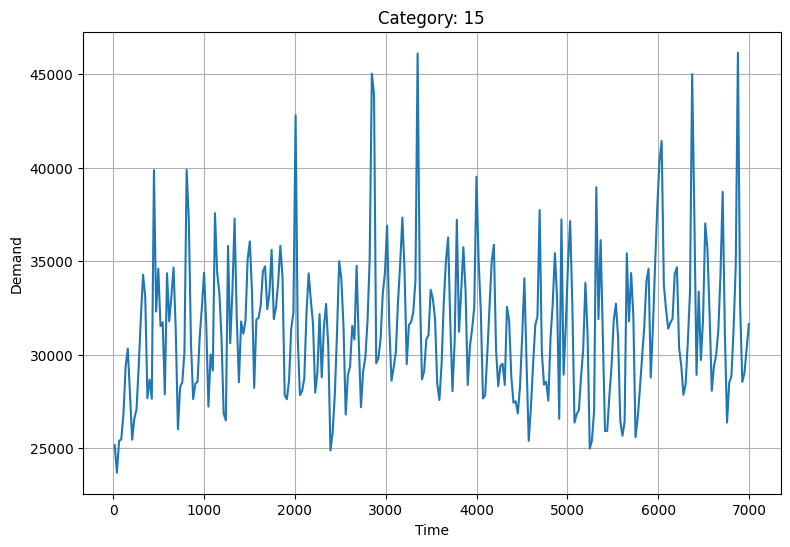

Augmented Dickey Fuller p-value: 0.008670
Stationary


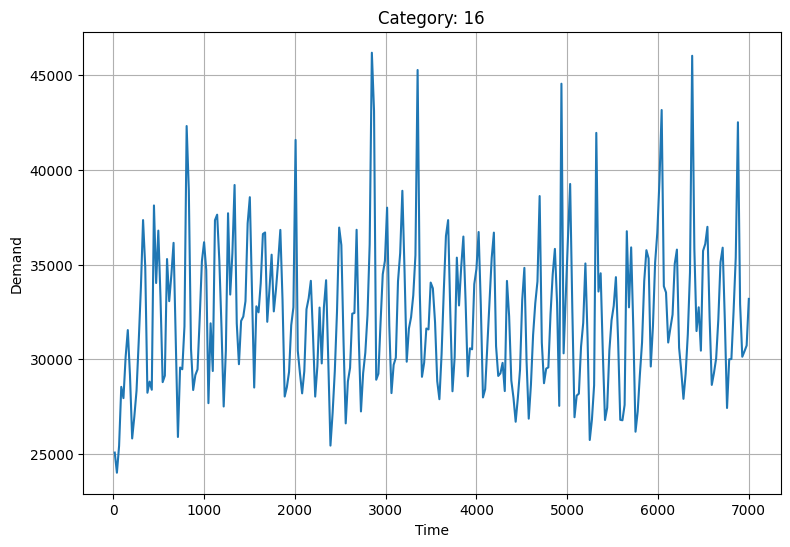

Augmented Dickey Fuller p-value: 0.006178
Stationary


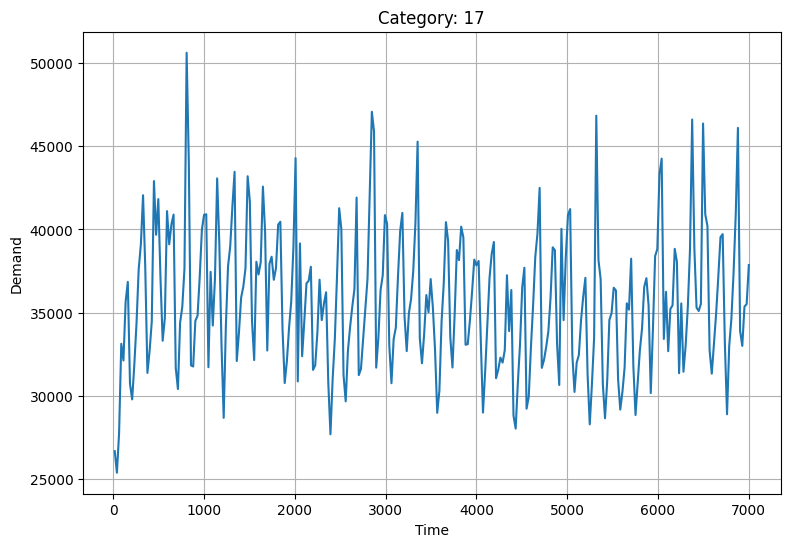

Augmented Dickey Fuller p-value: 0.029627
Stationary


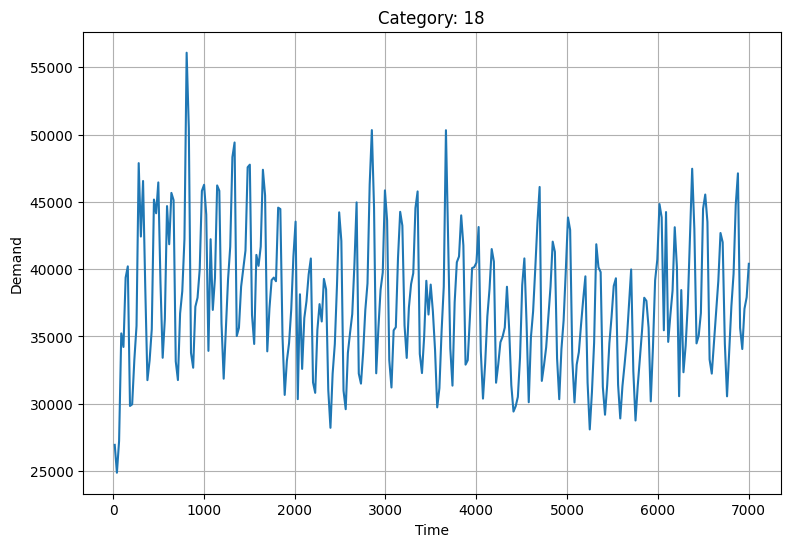

Augmented Dickey Fuller p-value: 0.131803
Not stationary


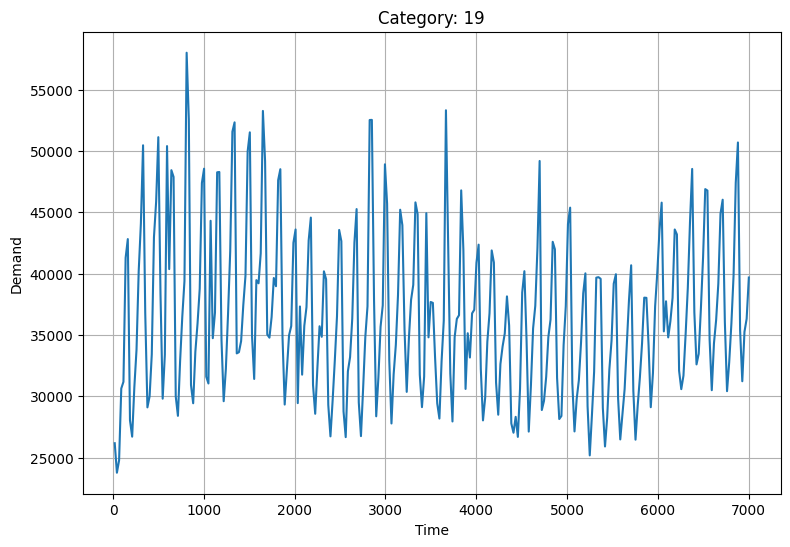

Augmented Dickey Fuller p-value: 0.201803
Not stationary


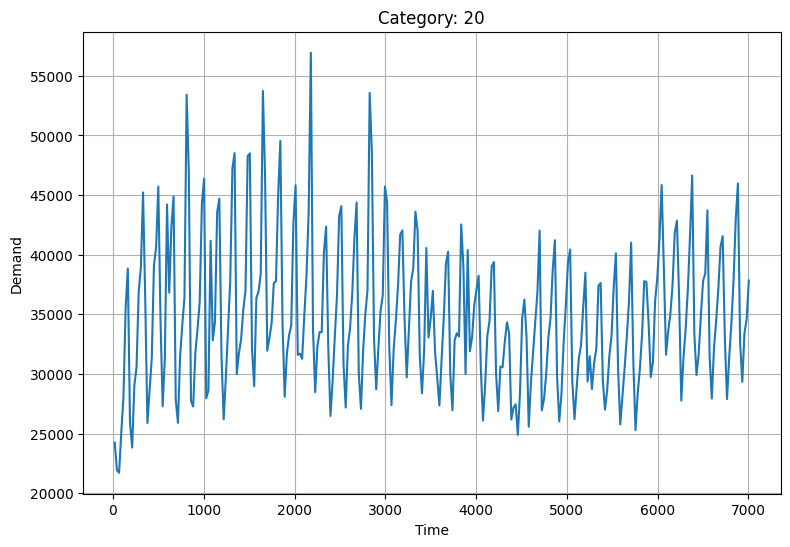

Augmented Dickey Fuller p-value: 0.109509
Not stationary


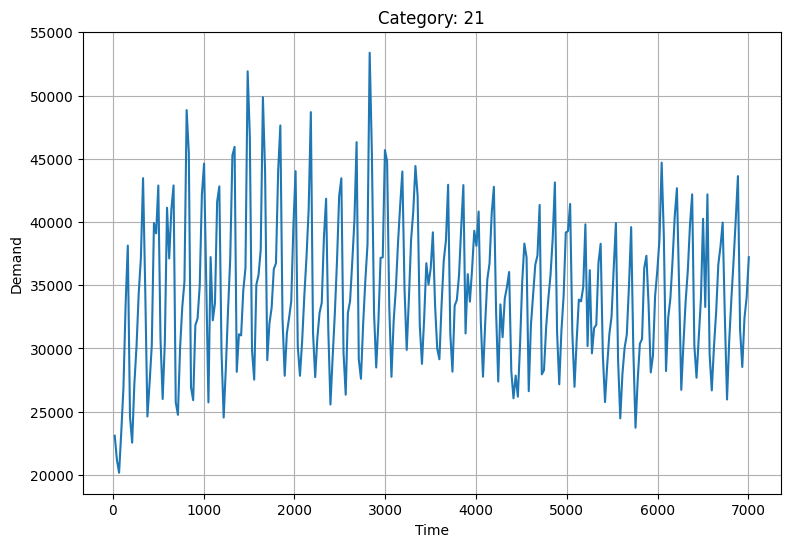

Augmented Dickey Fuller p-value: 0.016415
Stationary


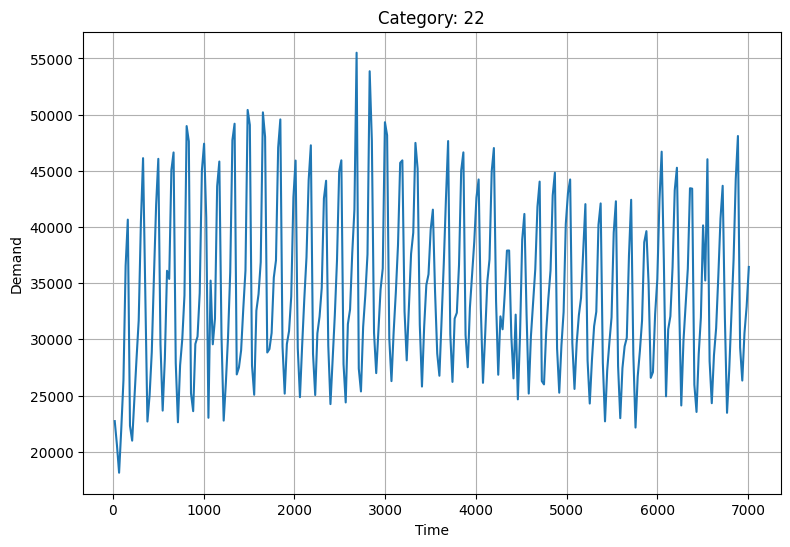

Augmented Dickey Fuller p-value: 0.018628
Stationary


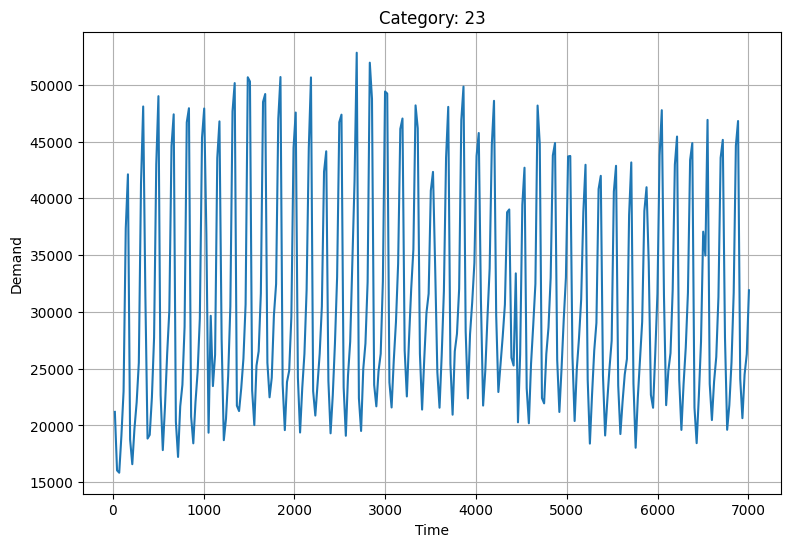

Augmented Dickey Fuller p-value: 0.017119
Stationary


In [ ]:
for key, df in df_dict.items():
  plt.figure(figsize=(9, 6))  # Create a new figure for each plot
  #plt.plot(df.index, df['order_count'], linestyle='-')  # Adjust as needed
  plt.plot(df['order_count'], linestyle='-')  # Adjust as needed
  plt.title(f"Category: {key}")
  plt.xlabel("Time")
  plt.ylabel("Demand")
  plt.grid(True)
  plt.show()  # Show the plot before moving to the next
  stationarity = adfuller(df['order_count'])
  print('Augmented Dickey Fuller p-value: %F' % stationarity[1])
  if(stationarity[1] > 0.05):
    print("Not stationary")
  else:
    print("Stationary")
  #df['order_count'].plot(figsize = (9,6))

<Figure size 900x600 with 0 Axes>

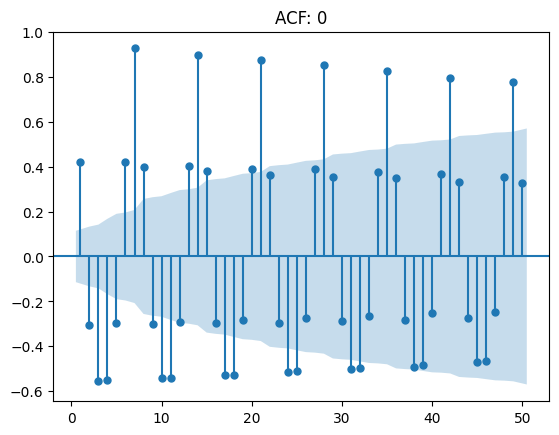

<Figure size 900x600 with 0 Axes>

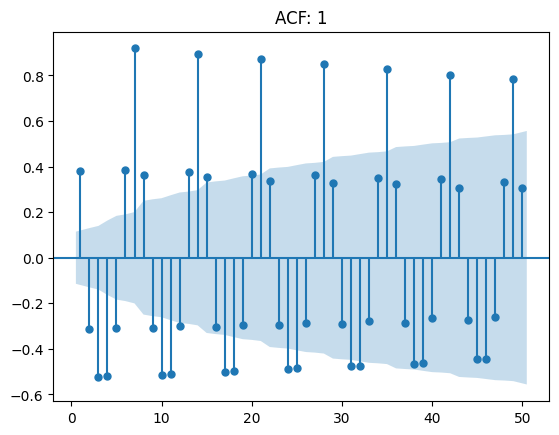

<Figure size 900x600 with 0 Axes>

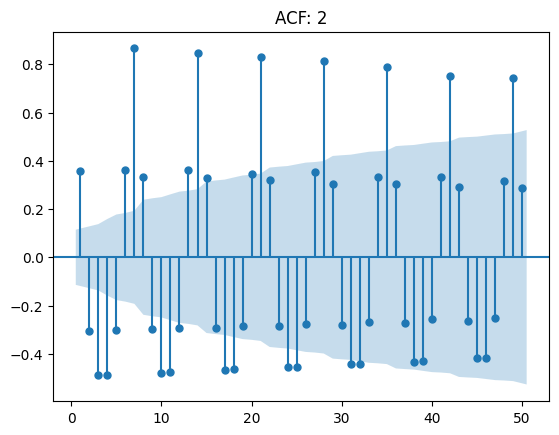

<Figure size 900x600 with 0 Axes>

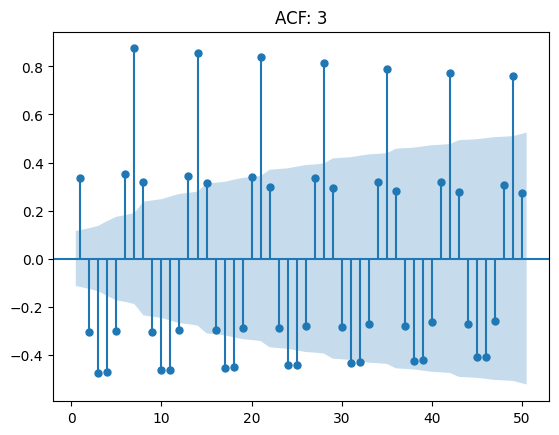

<Figure size 900x600 with 0 Axes>

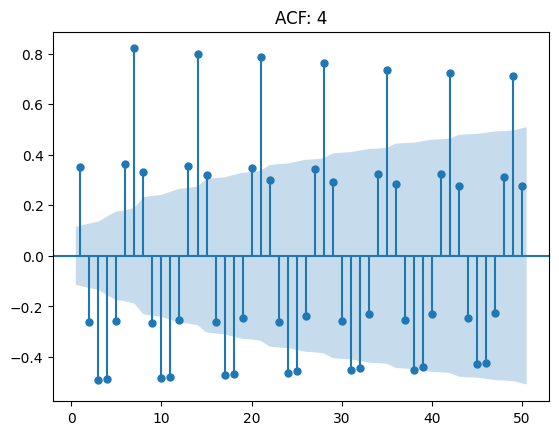

<Figure size 900x600 with 0 Axes>

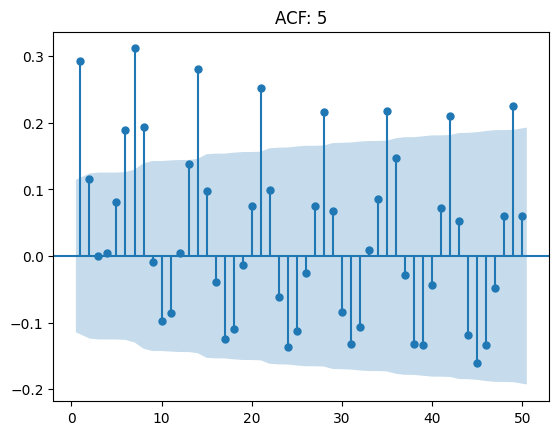

<Figure size 900x600 with 0 Axes>

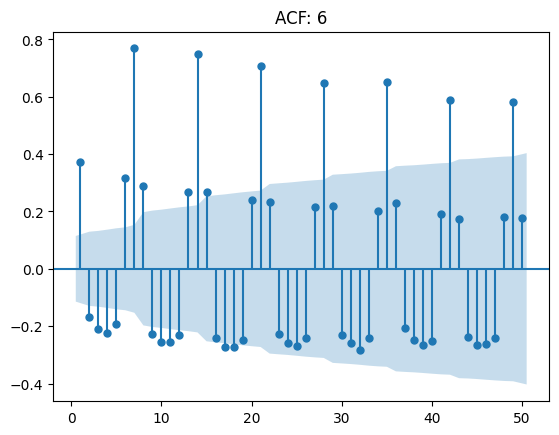

<Figure size 900x600 with 0 Axes>

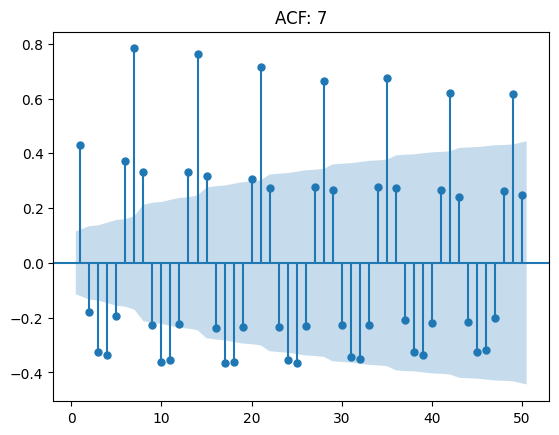

<Figure size 900x600 with 0 Axes>

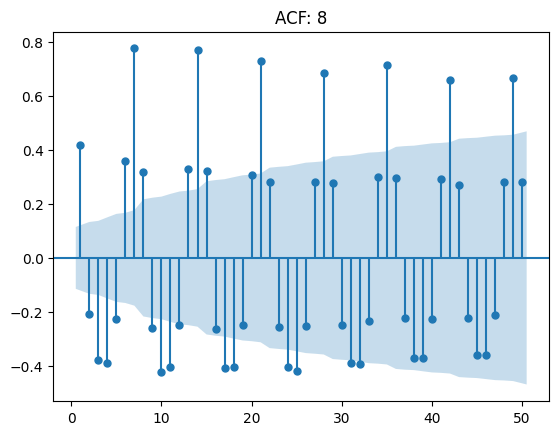

<Figure size 900x600 with 0 Axes>

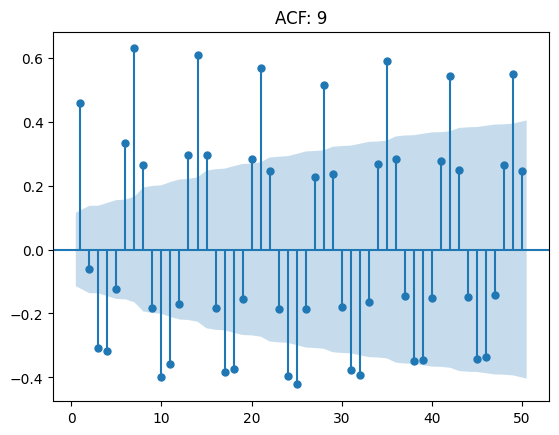

<Figure size 900x600 with 0 Axes>

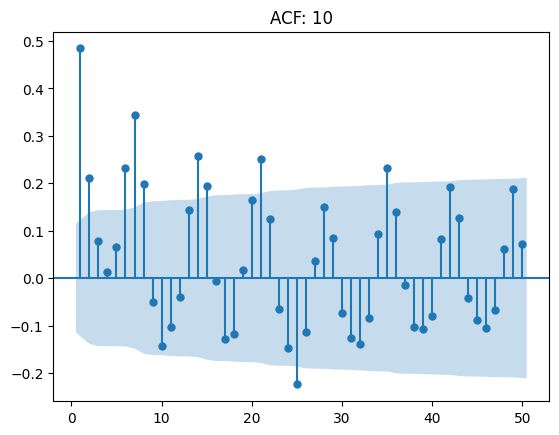

<Figure size 900x600 with 0 Axes>

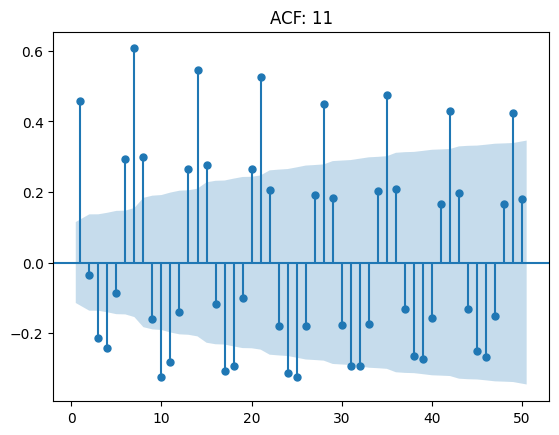

<Figure size 900x600 with 0 Axes>

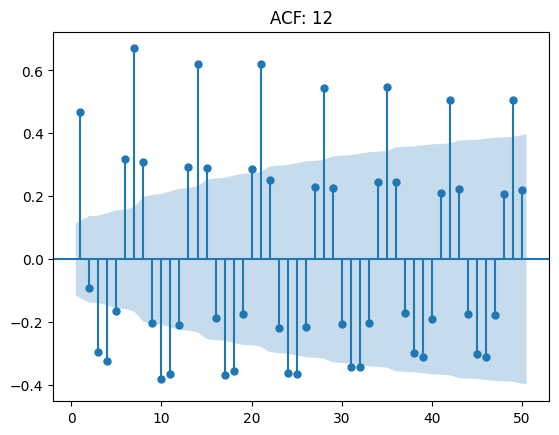

<Figure size 900x600 with 0 Axes>

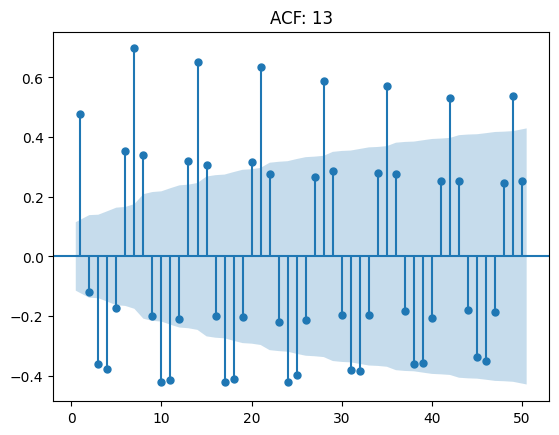

<Figure size 900x600 with 0 Axes>

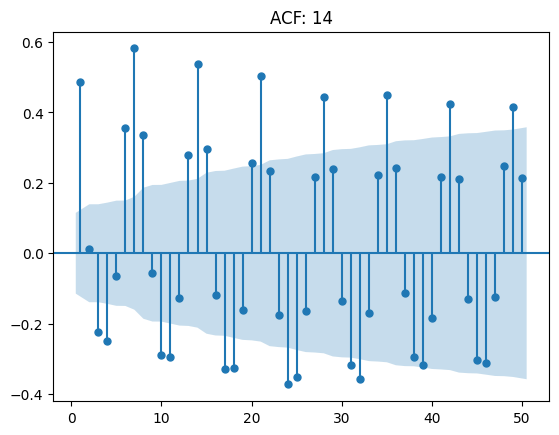

<Figure size 900x600 with 0 Axes>

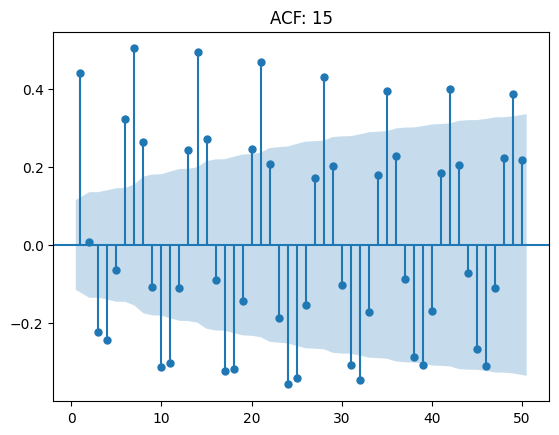

<Figure size 900x600 with 0 Axes>

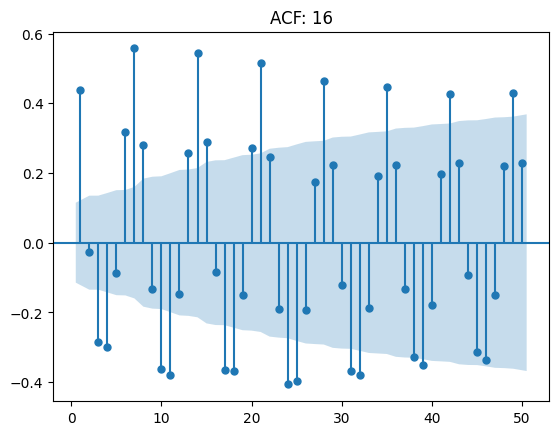

<Figure size 900x600 with 0 Axes>

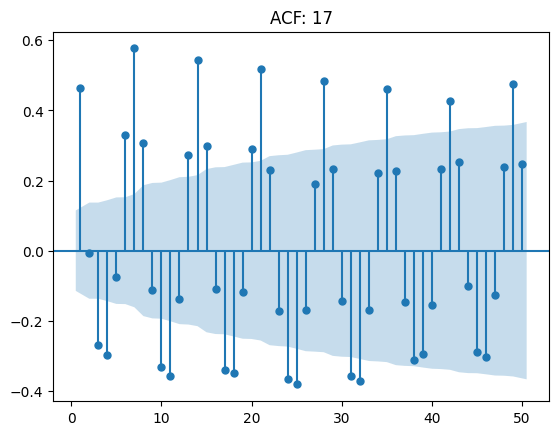

<Figure size 900x600 with 0 Axes>

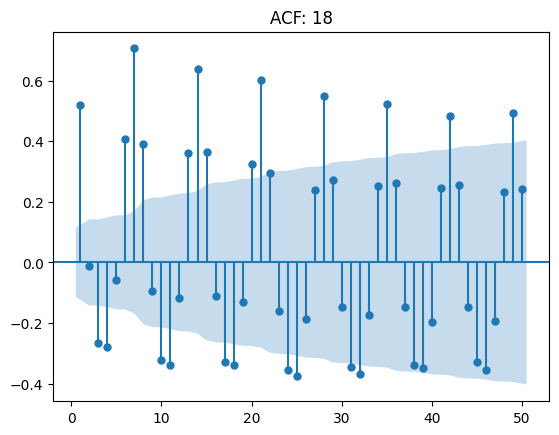

<Figure size 900x600 with 0 Axes>

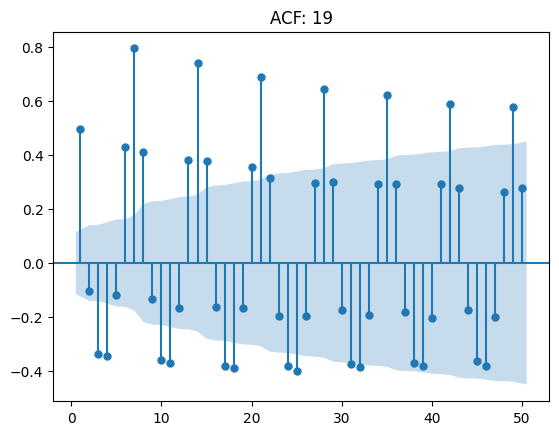

<Figure size 900x600 with 0 Axes>

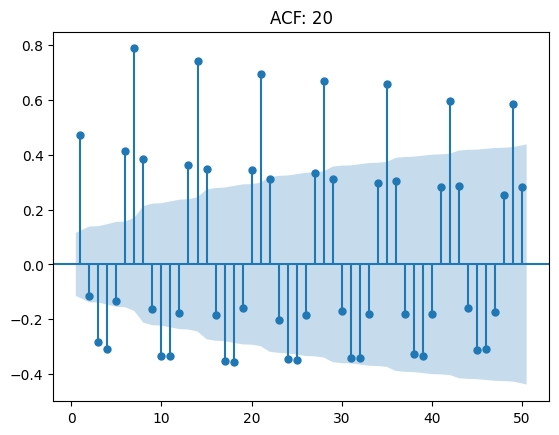

<Figure size 900x600 with 0 Axes>

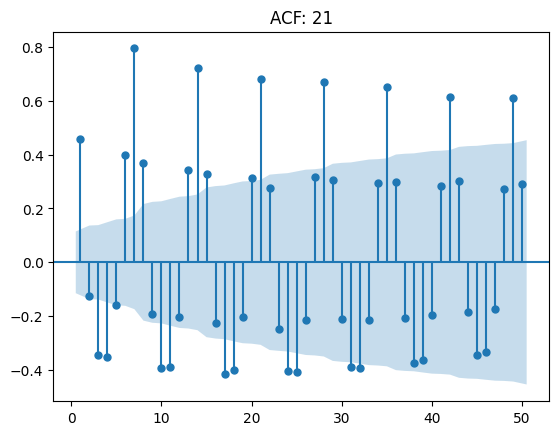

<Figure size 900x600 with 0 Axes>

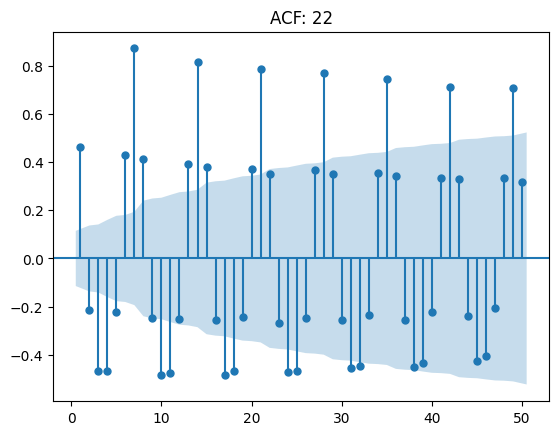

<Figure size 900x600 with 0 Axes>

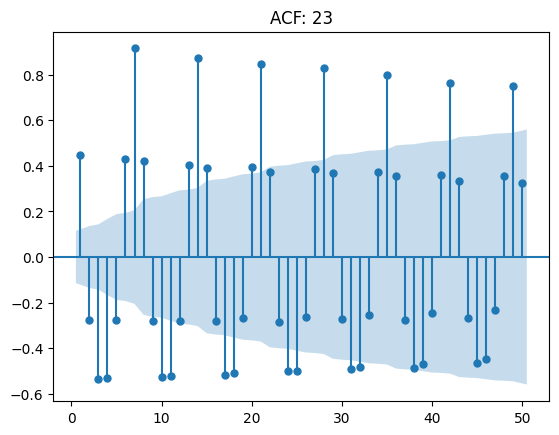

In [ ]:
for key, df in df_dict.items():
  plt.figure(figsize=(9, 6))  # Create a new figure for each plot
  sgt.plot_acf(df['order_count'], lags=50, alpha=0.05, zero=False)
  plt.title(f"ACF: {key}")
  #plt.title("ACF", size=20)
  plt.autoscale(enable=True, axis='y')
  plt.show()

<Figure size 900x600 with 0 Axes>

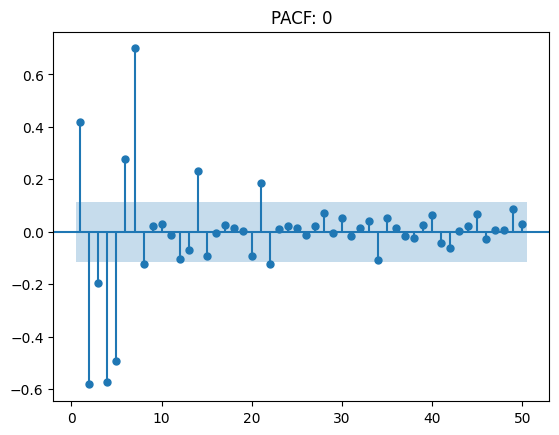

<Figure size 900x600 with 0 Axes>

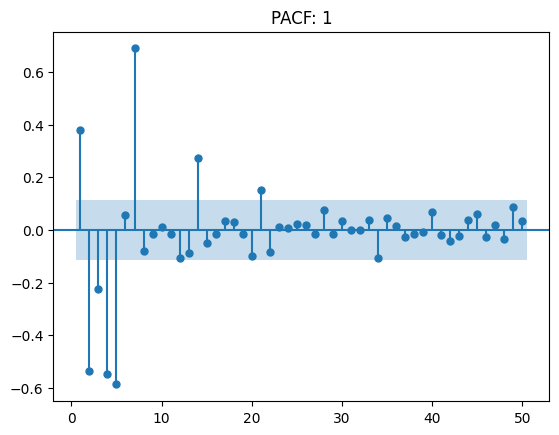

<Figure size 900x600 with 0 Axes>

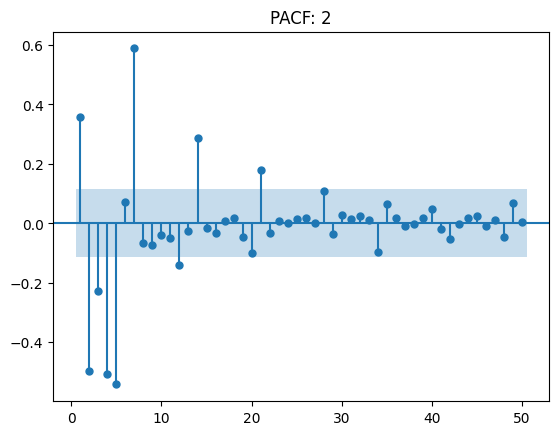

<Figure size 900x600 with 0 Axes>

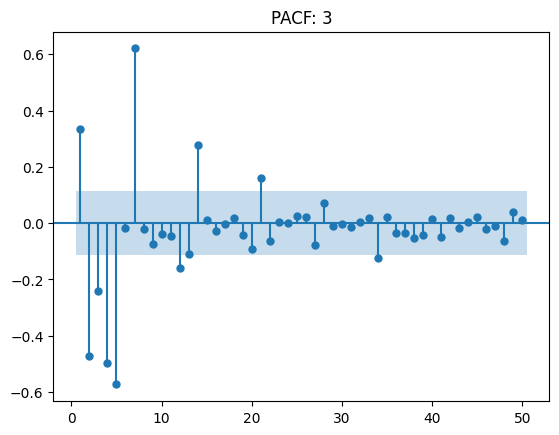

<Figure size 900x600 with 0 Axes>

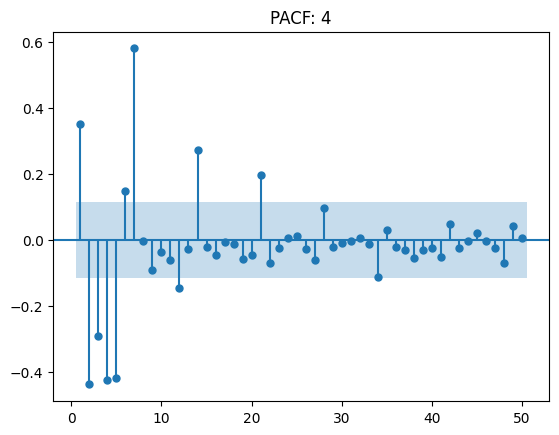

<Figure size 900x600 with 0 Axes>

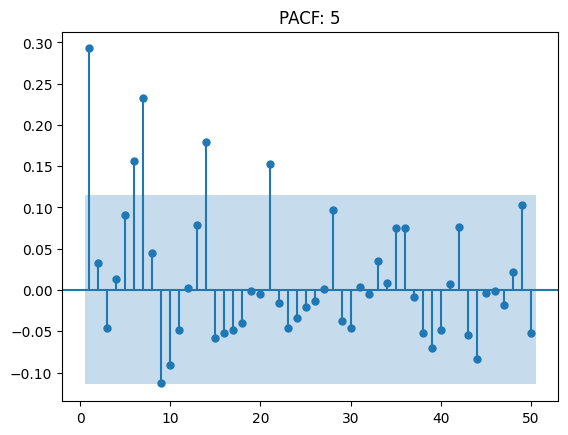

<Figure size 900x600 with 0 Axes>

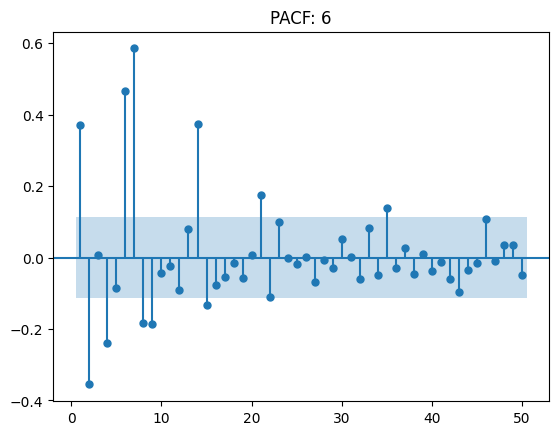

<Figure size 900x600 with 0 Axes>

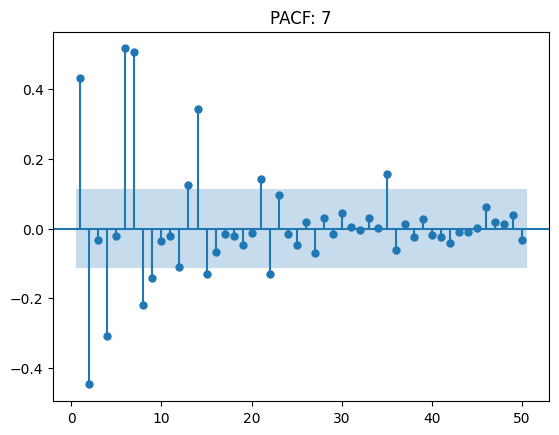

<Figure size 900x600 with 0 Axes>

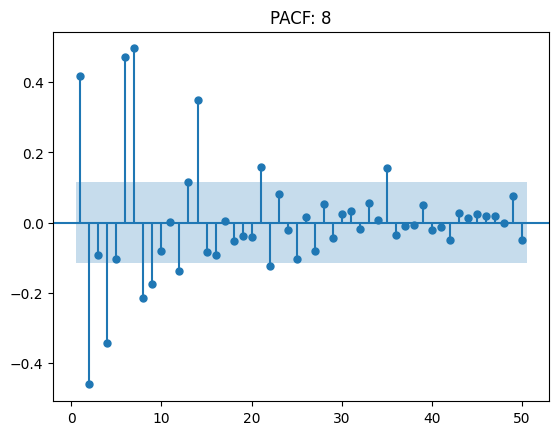

<Figure size 900x600 with 0 Axes>

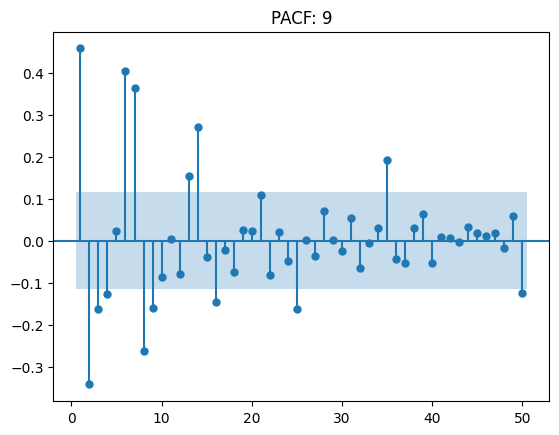

<Figure size 900x600 with 0 Axes>

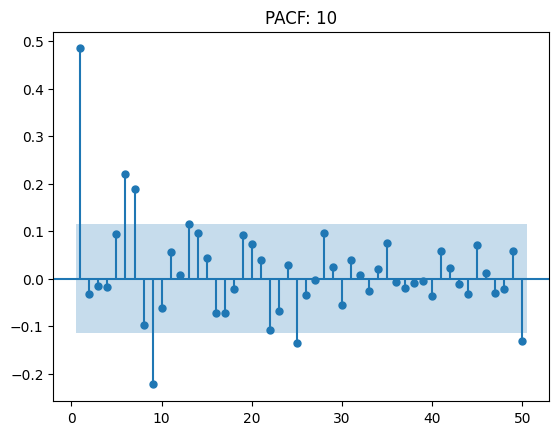

<Figure size 900x600 with 0 Axes>

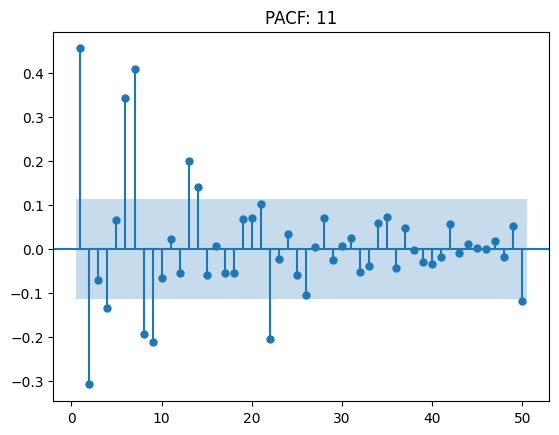

<Figure size 900x600 with 0 Axes>

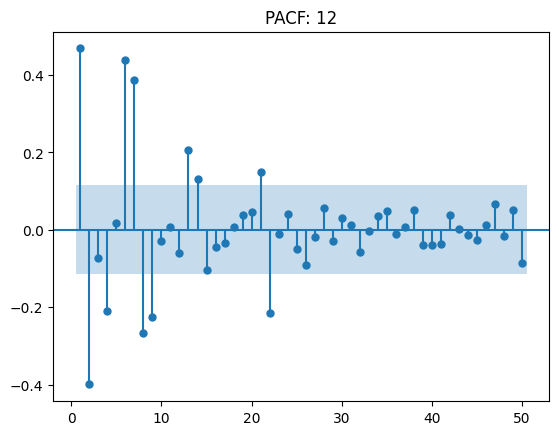

<Figure size 900x600 with 0 Axes>

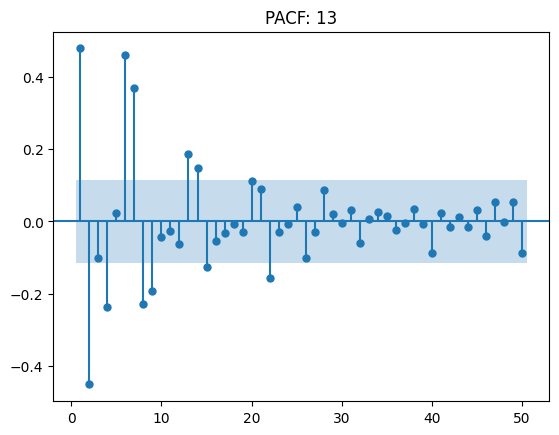

<Figure size 900x600 with 0 Axes>

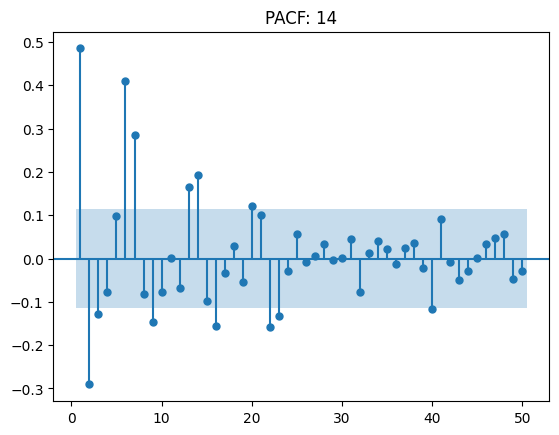

<Figure size 900x600 with 0 Axes>

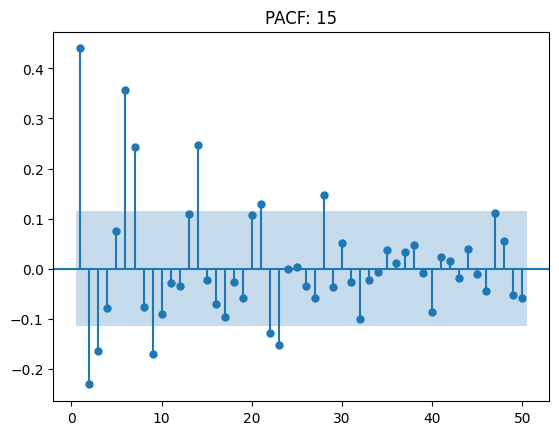

<Figure size 900x600 with 0 Axes>

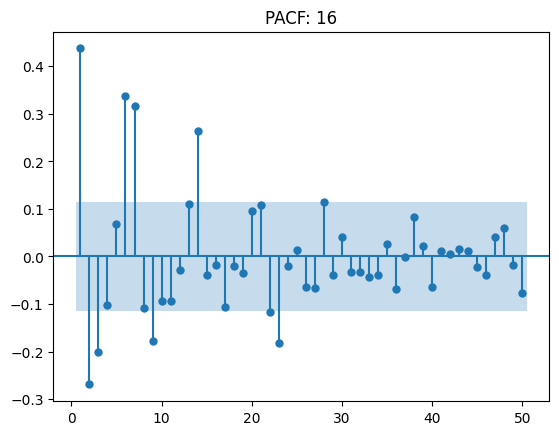

<Figure size 900x600 with 0 Axes>

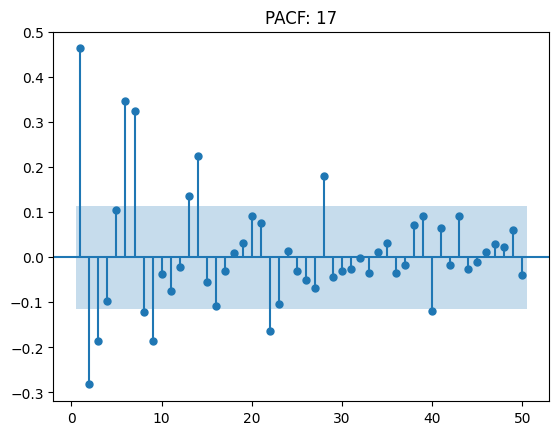

<Figure size 900x600 with 0 Axes>

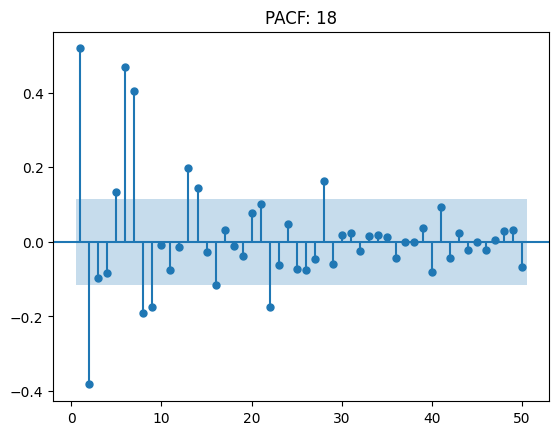

<Figure size 900x600 with 0 Axes>

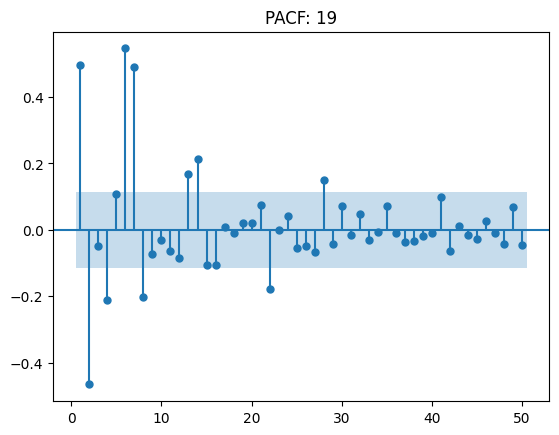

<Figure size 900x600 with 0 Axes>

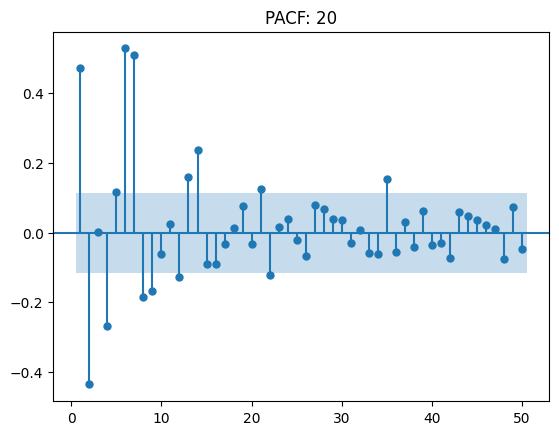

<Figure size 900x600 with 0 Axes>

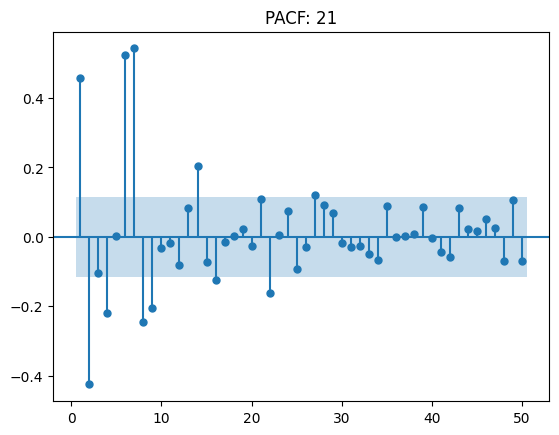

<Figure size 900x600 with 0 Axes>

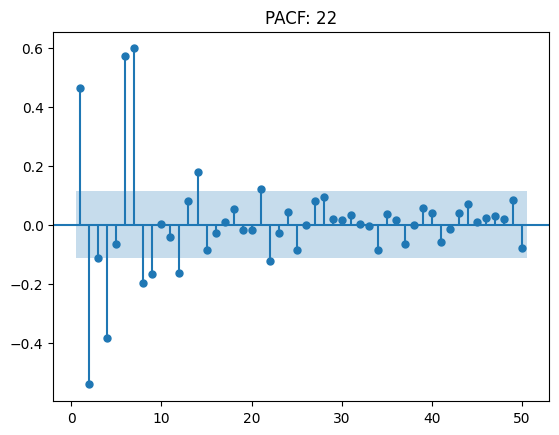

<Figure size 900x600 with 0 Axes>

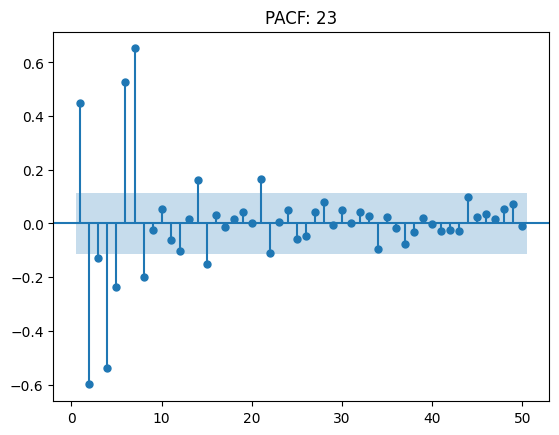

In [ ]:
for key, df in df_dict.items():
  plt.figure(figsize=(9, 6))  # Create a new figure for each plot
  sgt.plot_pacf(df['order_count'], lags=50, alpha=0.05, zero=False)
  plt.title(f"PACF: {key}")
  #plt.title("ACF", size=20)
  plt.autoscale(enable=True, axis='y')
  plt.show()

In [ ]:
len(df_dict[1])

293

#AUTO ARIMA

In [ ]:
#ARIMA - take a while to generate results
model_auto = auto_arima(y = train_set['order_count'],
                    test='adf', seasonal=True,
                    max_p=3, max_q=3, m=24,
                   stepwise = True)
model_auto.summary()

# END AUTO ARIMA

# PLOT GRAPH

In [ ]:
#Predictions (model1)
predictions = pd.Series(results_ar.predict(n_periods= len(df_combined) - train_size)).rename("ARIMA")
predictions.index = test_set.index
predictions.head(1)

ValueError: Length mismatch: Expected axis has 14035 elements, new values have 3509 elements

In [ ]:
train_set['order_count'].plot(legend = True, figsize = (9,6)) # Plot the entire training set
test_set['order_count'].plot(legend = True)
predictions.plot(legend = True)